# Packages incompatible issue

In [ ]:
!pip install --pre pycaret

In [ ]:
import pycaret
import scipy
from pycaret.classification import *

In [ ]:
!pip install matplotlib==3.1.3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 24.0 MB/s eta 0:00:00
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.6.3
    Uninstalling matplotlib-3.6.3:
      Successfully uninstalled matplotlib-3.6.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pycaret 3.0.0rc8 requires matplotlib>=3.3.0, but you have matplotlib 3.1.3 which is incompatible.


In [ ]:
import matplotlib

In [ ]:
print(matplotlib.__version__)

3.2.2


In [ ]:
!pip install numpy==1.21

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.7/15.7 MB 86.2 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.6
    Uninstalling numpy-1.21.6:
      Successfully uninstalled numpy-1.21.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pycaret 3.0.0rc8 requires matplotlib>=3.3.0, but you have matplotlib 3.1.3 which is incompatible.
pmdarima 2.0.2 requires numpy>=1.21.2, but you have numpy 1.21.0 which is incompatible.


In [ ]:
import numpy

In [ ]:
print(numpy.__version__)

1.21.6


In [ ]:
!pip install LightGBM

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import seaborn
import sklearn
import time
import re 
from collections import Counter
from imblearn.over_sampling import SMOTE

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

In [ ]:
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.ensemble import ExtraTreesClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import Pipeline

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('max_colwidth',300)
pd.set_option('display.float_format', lambda x: '%.2f'% x)

In [ ]:
os.listdir()

['.config', 'logs.log', 'sample_data']

In [ ]:
os.listdir("/gdrive/MyDrive/")

['Colab Notebooks', 'P7dataset']

# 1. Import datasets

In [ ]:
def duplicated_check(df, i): 
    duplicated_pk = df.duplicated(subset=df.columns[i]).sum() # check duplicated primary key
    n_unique = len(df[df.columns[i]].unique())
    duplicated_rows = df.duplicated().sum() # check duplicated rows
    return print(f'Duplicated primary keys: {duplicated_pk}'), print(f'Unique ID numbers: {n_unique}'), print(f'Duplicated rows: {duplicated_rows}')

In [ ]:
def absent_check(df):
    output = df.isna().mean()
    perc_col = len(output[output.values==0])/len(output)
    return print(f'Full columns percentage : {perc_col*100}')

In [ ]:
def anomalie_check(data):
    
    numerical_cols = [col for col in data.columns if data[col].dtypes!='object']
    subdata = data[numerical_cols]

    ax = plt.subplot()
    ax.boxplot(subdata)
    ax.set_xticklabels(subdata.columns, rotation=90, fontsize=8)
    #ax.set_xticklabels(rotation=75)
    return plt.show(ax)

In [ ]:
def OneHotEncoding(data):
    categorical_col = [col for col in data.columns if data[col].dtypes=='object']
    df_dummies = pd.get_dummies(data, columns=categorical_col, dummy_na = False)
    new_col = [col for col in df_dummies if col not in data.columns]
    return df_dummies, new_col

##Bureau with Bureau Balance
  1. Preprocess features in tables
  2. Merge bureau balance to bureau
  3. Create Active Credit, Closed Credit tables to aggregated bureau table

In [ ]:
def bureau_with_balance(nrows):
  #Preprocess bureau table
  bureau = pd.read_csv("/gdrive/MyDrive/P7dataset/bureau.csv", nrows=None)

  d_bureau, bureau_cat = OneHotEncoding(bureau)

  agg_bureau = d_bureau.groupby(['SK_ID_BUREAU', 'SK_ID_CURR']).agg('mean').reset_index()

 

#  #Preprocess bureau_balance table
  bureau_balance = pd.read_csv("/gdrive/MyDrive/P7dataset/bureau_balance.csv", nrows=None)
  d_bureau_balance, bureau_balance_cat = OneHotEncoding(bureau_balance)

  #Agregate hot features in bureau_balance
  num_aggs = {"MONTHS_BALANCE":['max', 'min', 'size']}
  num_aggs={}
  for num in d_bureau_balance.columns[2:]:
    num_aggs[num] = ['mean']
  agg_bureau_balance = d_bureau_balance.groupby('SK_ID_BUREAU').agg(num_aggs)
  agg_bureau_balance.columns = pd.Index([e[0] + '_' + e[1].upper() for e in agg_bureau_balance.columns.tolist()])
#
#  # Merge aggregated bureau balance into bureau
  agg_bureau_with_balance = agg_bureau.join(agg_bureau_balance, how='left', on='SK_ID_BUREAU')

  #count previous applications on the merged data
  previous_applications = agg_bureau_with_balance.groupby('SK_ID_CURR')['SK_ID_BUREAU'].count()
  client_information = pd.DataFrame(previous_applications).reset_index()
  client_information.columns=['SK_ID_CURR', 'PREVIOUS_APPLICATIONS']
  #regroup merged table by ID_CURR
  agg_bureau_with_balance.drop(columns='SK_ID_BUREAU', inplace=True)
  agg_bureau_with_balance = agg_bureau_with_balance.groupby('SK_ID_CURR').mean().reset_index()
  
  agg_bureau_with_balance.drop_duplicates(subset='SK_ID_CURR', inplace=True)


  return agg_bureau_with_balance, client_information


In [ ]:
agg_bureau_with_balance, bb_info = bureau_with_balance(None)
agg_bureau_with_balance.head(6)

SK_ID_CURR  DAYS_CREDIT  CREDIT_DAY_OVERDUE  DAYS_CREDIT_ENDDATE  \
0      100001      -735.00                0.00                82.43   
1      100002      -874.00                0.00              -349.00   
2      100003     -1400.75                0.00              -544.50   
3      100004      -867.00                0.00              -488.50   
4      100005      -190.67                0.00               439.33   
5      100007     -1149.00                0.00              -783.00   

   DAYS_ENDDATE_FACT  AMT_CREDIT_MAX_OVERDUE  CNT_CREDIT_PROLONG  \
0            -825.50                     NaN                0.00   
1            -697.50                 1681.03                0.00   
2           -1097.33                    0.00                0.00   
3            -532.50                    0.00                0.00   
4            -123.00                    0.00                0.00   
5            -783.00                    0.00                0.00   

   AMT_CREDIT_SUM  AMT_CREDIT_SUM_DEBT  AMT_CREDIT_SUM_LIMIT  \
0       207623.57             85240.93                  0.00   
1       108131.95             49156.20               7997.14   
2       254350.12                 0.00             202500.00   
3        94518.90                 0.00                  0.00   
4       219042.00            189469.50                  0.00   
5       146250.00                 0.00                  0.00   

   AMT_CREDIT_SUM_OVERDUE  DAYS_CREDIT_UPDATE  AMT_ANNUITY  \
0                    0.00              -93.14      3545.36   
1                    0.00             -499.88         0.00   
2                    0.00             -816.00          NaN   
3                    0.00             -532.00          NaN   
4                    0.00              -54.33      1420.50   
5                    0.00             -783.00          NaN   

   CREDIT_ACTIVE_Active  CREDIT_ACTIVE_Bad debt  CREDIT_ACTIVE_Closed  \
0                  0.43                    0.00                  0.57   
1                  0.25                    0.00                  0.75   
2                  0.25                    0.00                  0.75   
3                  0.00                    0.00                  1.00   
4                  0.67                    0.00                  0.33   
5                  0.00                    0.00                  1.00   

   CREDIT_ACTIVE_Sold  CREDIT_CURRENCY_currency 1  CREDIT_CURRENCY_currency 2  \
0                0.00                        1.00                        0.00   
1                0.00                        1.00                        0.00   
2                0.00                        1.00                        0.00   
3                0.00                        1.00                        0.00   
4                0.00                        1.00                        0.00   
5                0.00                        1.00                        0.00   

   CREDIT_CURRENCY_currency 3  CREDIT_CURRENCY_currency 4  \
0                        0.00                        0.00   
1                        0.00                        0.00   
2                        0.00                        0.00   
3                        0.00                        0.00   
4                        0.00                        0.00   
5                        0.00                        0.00   

   CREDIT_TYPE_Another type of loan  CREDIT_TYPE_Car loan  \
0                              0.00                  0.00   
1                              0.00                  0.00   
2                              0.00                  0.00   
3                              0.00                  0.00   
4                              0.00                  0.00   
5                              0.00                  0.00   

   CREDIT_TYPE_Cash loan (non-earmarked)  CREDIT_TYPE_Consumer credit  \
0                                   0.00                         1.00   
1                                   0.00                      

In [ ]:
print(agg_bureau_with_balance.shape, bb_info.shape)

(305811, 44) (305811, 2)


In [ ]:
bb_info.head()

SK_ID_CURR  PREVIOUS_APPLICATIONS
0      100001                      7
1      100002                      8
2      100003                      4
3      100004                      2
4      100005                      3

In [ ]:
agg_bureau_with_balance.to_csv("csv_1.csv", index=False)
!cp csv_1.csv "/gdrive/MyDrive/P7dataset/"

In [ ]:
# Preprocess credit_card_balance.csv
def prev_cc():
    # credit card balance
    cc = pd.read_csv('/gdrive/MyDrive/P7dataset/credit_card_balance.csv')
    
    cc, cc_cat = OneHotEncoding(cc)
    cc_agg = cc.groupby(['SK_ID_PREV', 'SK_ID_CURR']).agg('mean')
    cc_agg.columns = pd.Index(['CC_' + e for e in cc_agg.columns.tolist()])
    cc_agg.reset_index(inplace=True)
    del cc
    return cc_agg

# Preprocess payment_installmnt table
def prev_ins():
    ins = payment_installmnt = pd.read_csv("/gdrive/MyDrive/P7dataset/installments_payments.csv", nrows=None) # all columns are numerical type

    num_aggs = {
      'NUM_INSTALMENT_VERSION': ['nunique'],
      'DPD': ['max', 'mean', 'sum'],
      'DBD': ['max', 'mean', 'sum'],
      'PAYMENT_PERC': ['max', 'mean', 'sum'],
      'PAYMENT_DIFF': ['max', 'mean', 'sum'],
      'AMT_INSTALMENT': ['max', 'mean', 'sum'],
      'AMT_PAYMENT': ['min', 'max', 'mean'],
      'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']}
    num_aggs={}
    for num in ins.columns[2:-2]:
      num_aggs[num] = ['mean']
      ins_agg = ins.groupby(['SK_ID_PREV', 'SK_ID_CURR']).agg('mean')
      ins_agg.columns = pd.Index(['INS_' + e[0] + '_' + e[1].upper() for e in ins_agg.columns.tolist()])
      ins_agg.reset_index(inplace=True)
    del ins
    return ins_agg


# preprocess pos cash balance table
def prev_pos_cash():
  # add pos cash balance into merge
  poscash_balance = pd.read_csv("/gdrive/MyDrive/P7dataset/POS_CASH_balance.csv", nrows=None)

  d_pos, pos_cat = OneHotEncoding(poscash_balance)
  aggs = {
      "MONTHS_BALANCE": ['max', 'min', 'size'],
      "CNT_INSTALMENT": ['max','mean'],
      "CNT_INSTALMENT_FUTURE": ['max','mean'],
      "SK_DPD": ['max','mean'],
      "SK_DPD_DEF": ['max','mean']}
  for col in pos_cat:
      aggs[col] = 'mean'
  pos_agg = d_pos.groupby(['SK_ID_PREV', 'SK_ID_CURR']).agg(aggs)
  pos_agg.columns = pd.Index(['POSCASH_' + e[0] + '_' + e[1].upper() for e in pos_agg.columns.tolist()])
  pos_agg.reset_index(inplace=True)
  del d_pos
  return pos_agg


In [ ]:
# preprocess previous application table
def prev_prev_appli():
    prev = pd.read_csv('/gdrive/MyDrive/P7dataset/previous_application.csv')

    prev, prev_cat = OneHotEncoding(prev)
    
    # Previous applications numeric features
    numerical_col = [col for col in prev.columns if prev[col].dtypes != 'object']

    num_aggregations = {
        'AMT_ANNUITY': ['mean', 'sum'],
        'AMT_APPLICATION': ['min', 'max', 'mean'],
        'AMT_CREDIT': ['mean', 'sum'],
        'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
        'HOUR_APPR_PROCESS_START': ['max'],
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum'],
        'RATE_INTEREST_PRIMARY' : ['mean'],
        'NFLAG_LAST_APPL_IN_DAY' : ['mean'],
        'RATE_INTEREST_PRIMARY': ['mean'],
        'RATE_INTEREST_PRIVILEGED': ['mean'],
        'SELLERPLACE_AREA': ['mean'],
        'DAYS_FIRST_DRAWING': ['mean'],
        'DAYS_FIRST_DUE': ['mean'],
        'DAYS_LAST_DUE_1ST_VERSION': ['mean'],
        'DAYS_LAST_DUE': ['mean'],
        'DAYS_TERMINATION': ['mean'],
        'NFLAG_INSURED_ON_APPROVAL': ['mean']}

    # Previous applications categorical features
    cat_aggregations = {}
    for cat in prev_cat:
        cat_aggregations[cat] = ['mean']
    
    prev_agg = prev.groupby(['SK_ID_PREV', 'SK_ID_CURR']).agg({**num_aggregations, **cat_aggregations})
    prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])
    prev_agg.reset_index(inplace=True)

    return prev_agg

In [ ]:
def prev_merge():
  agg_cc= prev_cc()
  agg_ins= prev_ins()
  temp = agg_cc.merge(agg_ins, how='outer', on = ['SK_ID_PREV', 'SK_ID_CURR'])
  del agg_cc, agg_ins
  
  agg_pos = prev_pos_cash()
  temp = temp.merge(agg_pos, how='outer', on= ['SK_ID_PREV', 'SK_ID_CURR'])
  del agg_pos

  agg_prev= prev_prev_appli()
  temp = temp.merge(agg_prev, how='outer', on= ['SK_ID_PREV', 'SK_ID_CURR'])
  del agg_prev

  #print(temp.columns)

  #count previous applications 
  previous_applications = temp.groupby('SK_ID_CURR')['SK_ID_PREV'].count()
  pa = pd.DataFrame(previous_applications).reset_index()
  pa.columns=['SK_ID_CURR', 'PREVIOUS_APPLICATIONS']
  temp = temp.merge(pa, how='left', on='SK_ID_CURR')
  client_information = temp.loc[:, ['SK_ID_CURR', 'PREVIOUS_APPLICATIONS']]
  client_information.drop_duplicates(subset='SK_ID_CURR', inplace=True)

  df_prev = temp.drop(columns= 'SK_ID_PREV')
  df_prev = df_prev.groupby('SK_ID_CURR').mean()
  df_prev.reset_index(inplace=True)
  df_prev = df_prev.drop_duplicates(subset='SK_ID_CURR')


  return df_prev, client_information

In [ ]:
df_prev, prev_client_information = prev_merge()

In [ ]:
print(df_prev.shape, prev_client_information.shape)
prev_client_information.head()

(340964, 230) (340964, 2)


SK_ID_CURR  PREVIOUS_APPLICATIONS
0      394447                      6
1      361282                      2
2      131335                      6
3      436351                     13
4      181153                     10

In [ ]:
df_prev.to_csv("csv_2.csv", index=False)
!cp csv_2.csv "/gdrive/MyDrive/P7dataset/"

In [ ]:
# merge previous applications for clients that from bureau merged table and clients that from prev merged table
info =pd.concat([bb_info, prev_client_information], axis=0)
print(info.shape)
info.drop_duplicates(subset='SK_ID_CURR', inplace=True)
print(info.shape) # got 353895 clients uniques

(646775, 2)
(353895, 2)


In [ ]:
# Preprocess application_train.csv and application_test.csv
def application():
    # Read data and merge
    train = pd.read_csv("/gdrive/MyDrive/P7dataset/application_train.csv")
    test = pd.read_csv("/gdrive/MyDrive/P7dataset/application_test.csv")
    print("Train samples: {}, test samples: {}".format(len(train), len(test)))
    
    df = train.append(test).reset_index(drop=True)
    # Optional: Remove 4 applications with XNA CODE_GENDER (train set)
    #df = df[df['CODE_GENDER'] != 'XNA']
    df['AGE'] = abs(df['DAYS_BIRTH']/365)
    df['AGE'] = df['AGE'].astype('int')
    #df['CNT_FAM_MEMBERS'] = df['CNT_FAM_MEMBERS'].astype('int')
    #df = df.drop('DAYS_BIRTH')
    client_information = df.loc[:, ['SK_ID_CURR', 'CODE_GENDER', 'AMT_INCOME_TOTAL', 'NAME_INCOME_TYPE','NAME_CONTRACT_TYPE', 'AMT_ANNUITY', 'AGE']]
    # Categorical features with Binary encode (0 or 1; two categories)
    for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
        df[bin_feature], uniques = pd.factorize(df[bin_feature])
    # Categorical features with One-Hot encode
    app_agg, cat_cols = OneHotEncoding(df)

    del train, test

    return app_agg, client_information

In [ ]:
app_agg, app_client_info = application()
app_agg.shape

Train samples: 307511, test samples: 48744


(356255, 243)

# General table

In [ ]:
print(agg_bureau_with_balance.shape)
agg_bureau_with_balance.head(0)

(305811, 44)


Empty DataFrame
Columns: [SK_ID_CURR, DAYS_CREDIT, CREDIT_DAY_OVERDUE, DAYS_CREDIT_ENDDATE, DAYS_ENDDATE_FACT, AMT_CREDIT_MAX_OVERDUE, CNT_CREDIT_PROLONG, AMT_CREDIT_SUM, AMT_CREDIT_SUM_DEBT, AMT_CREDIT_SUM_LIMIT, AMT_CREDIT_SUM_OVERDUE, DAYS_CREDIT_UPDATE, AMT_ANNUITY, CREDIT_ACTIVE_Active, CREDIT_ACTIVE_Bad debt, CREDIT_ACTIVE_Closed, CREDIT_ACTIVE_Sold, CREDIT_CURRENCY_currency 1, CREDIT_CURRENCY_currency 2, CREDIT_CURRENCY_currency 3, CREDIT_CURRENCY_currency 4, CREDIT_TYPE_Another type of loan, CREDIT_TYPE_Car loan, CREDIT_TYPE_Cash loan (non-earmarked), CREDIT_TYPE_Consumer credit, CREDIT_TYPE_Credit card, CREDIT_TYPE_Interbank credit, CREDIT_TYPE_Loan for business development, CREDIT_TYPE_Loan for purchase of shares (margin lending), CREDIT_TYPE_Loan for the purchase of equipment, CREDIT_TYPE_Loan for working capital replenishment, CREDIT_TYPE_Microloan, CREDIT_TYPE_Mobile operator loan, CREDIT_TYPE_Mortgage, CREDIT_TYPE_Real estate loan, CREDIT_TYPE_Unknown type of loan, STATUS_0_MEAN, STATUS_1_MEAN, STATUS_2_MEAN, STATUS_3_MEAN, STATUS_4_MEAN, STATUS_5_MEAN, STATUS_C_MEAN, STATUS_X_MEAN]
Index: []

In [ ]:
print(df_prev.shape)
df_prev.head(0)

(340964, 230)


Empty DataFrame
Columns: [SK_ID_CURR, CC_MONTHS_BALANCE, CC_AMT_BALANCE, CC_AMT_CREDIT_LIMIT_ACTUAL, CC_AMT_DRAWINGS_ATM_CURRENT, CC_AMT_DRAWINGS_CURRENT, CC_AMT_DRAWINGS_OTHER_CURRENT, CC_AMT_DRAWINGS_POS_CURRENT, CC_AMT_INST_MIN_REGULARITY, CC_AMT_PAYMENT_CURRENT, CC_AMT_PAYMENT_TOTAL_CURRENT, CC_AMT_RECEIVABLE_PRINCIPAL, CC_AMT_RECIVABLE, CC_AMT_TOTAL_RECEIVABLE, CC_CNT_DRAWINGS_ATM_CURRENT, CC_CNT_DRAWINGS_CURRENT, CC_CNT_DRAWINGS_OTHER_CURRENT, CC_CNT_DRAWINGS_POS_CURRENT, CC_CNT_INSTALMENT_MATURE_CUM, CC_SK_DPD, CC_SK_DPD_DEF, CC_NAME_CONTRACT_STATUS_Active, CC_NAME_CONTRACT_STATUS_Approved, CC_NAME_CONTRACT_STATUS_Completed, CC_NAME_CONTRACT_STATUS_Demand, CC_NAME_CONTRACT_STATUS_Refused, CC_NAME_CONTRACT_STATUS_Sent proposal, CC_NAME_CONTRACT_STATUS_Signed, INS_N_U, INS_N_U, INS_D_A, INS_D_A, INS_A_M, INS_A_M, POSCASH_MONTHS_BALANCE_MAX, POSCASH_MONTHS_BALANCE_MIN, POSCASH_MONTHS_BALANCE_SIZE, POSCASH_CNT_INSTALMENT_MAX, POSCASH_CNT_INSTALMENT_MEAN, POSCASH_CNT_INSTALMENT_FUTURE_MAX, POSCASH_CNT_INSTALMENT_FUTURE_MEAN, POSCASH_SK_DPD_MAX, POSCASH_SK_DPD_MEAN, POSCASH_SK_DPD_DEF_MAX, POSCASH_SK_DPD_DEF_MEAN, POSCASH_NAME_CONTRACT_STATUS_Active_MEAN, POSCASH_NAME_CONTRACT_STATUS_Amortized debt_MEAN, POSCASH_NAME_CONTRACT_STATUS_Approved_MEAN, POSCASH_NAME_CONTRACT_STATUS_Canceled_MEAN, POSCASH_NAME_CONTRACT_STATUS_Completed_MEAN, POSCASH_NAME_CONTRACT_STATUS_Demand_MEAN, POSCASH_NAME_CONTRACT_STATUS_Returned to the store_MEAN, POSCASH_NAME_CONTRACT_STATUS_Signed_MEAN, POSCASH_NAME_CONTRACT_STATUS_XNA_MEAN, PREV_AMT_ANNUITY_MEAN, PREV_AMT_ANNUITY_SUM, PREV_AMT_APPLICATION_MIN, PREV_AMT_APPLICATION_MAX, PREV_AMT_APPLICATION_MEAN, PREV_AMT_CREDIT_MEAN, PREV_AMT_CREDIT_SUM, PREV_AMT_DOWN_PAYMENT_MIN, PREV_AMT_DOWN_PAYMENT_MAX, PREV_AMT_DOWN_PAYMENT_MEAN, PREV_AMT_GOODS_PRICE_MIN, PREV_AMT_GOODS_PRICE_MAX, PREV_AMT_GOODS_PRICE_MEAN, PREV_HOUR_APPR_PROCESS_START_MAX, PREV_RATE_DOWN_PAYMENT_MIN, PREV_RATE_DOWN_PAYMENT_MAX, PREV_RATE_DOWN_PAYMENT_MEAN, PREV_DAYS_DECISION_MIN, PREV_DAYS_DECISION_MAX, PREV_DAYS_DECISION_MEAN, PREV_CNT_PAYMENT_MEAN, PREV_CNT_PAYMENT_SUM, PREV_RATE_INTEREST_PRIMARY_MEAN, PREV_NFLAG_LAST_APPL_IN_DAY_MEAN, PREV_RATE_INTEREST_PRIVILEGED_MEAN, PREV_SELLERPLACE_AREA_MEAN, PREV_DAYS_FIRST_DRAWING_MEAN, PREV_DAYS_FIRST_DUE_MEAN, PREV_DAYS_LAST_DUE_1ST_VERSION_MEAN, PREV_DAYS_LAST_DUE_MEAN, PREV_DAYS_TERMINATION_MEAN, PREV_NFLAG_INSURED_ON_APPROVAL_MEAN, PREV_NAME_CONTRACT_TYPE_Cash loans_MEAN, PREV_NAME_CONTRACT_TYPE_Consumer loans_MEAN, PREV_NAME_CONTRACT_TYPE_Revolving loans_MEAN, PREV_NAME_CONTRACT_TYPE_XNA_MEAN, PREV_WEEKDAY_APPR_PROCESS_START_FRIDAY_MEAN, PREV_WEEKDAY_APPR_PROCESS_START_MONDAY_MEAN, PREV_WEEKDAY_APPR_PROCESS_START_SATURDAY_MEAN, PREV_WEEKDAY_APPR_PROCESS_START_SUNDAY_MEAN, PREV_WEEKDAY_APPR_PROCESS_START_THURSDAY_MEAN, PREV_WEEKDAY_APPR_PROCESS_START_TUESDAY_MEAN, PREV_WEEKDAY_APPR_PROCESS_START_WEDNESDAY_MEAN, PREV_FLAG_LAST_APPL_PER_CONTRACT_N_MEAN, PREV_FLAG_LAST_APPL_PER_CONTRACT_Y_MEAN, PREV_NAME_CASH_LOAN_PURPOSE_Building a house or an annex_MEAN, ...]
Index: []

In [ ]:
print(app_agg.shape)
app_agg.head()

(356255, 243)


SK_ID_CURR  TARGET  CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  \
0      100002    1.00            0             0                0   
1      100003    0.00            1             0                1   
2      100004    0.00            0             1                0   
3      100006    0.00            1             0                0   
4      100007    0.00            0             0                0   

   CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0             0         202500.00   406597.50     24700.50        351000.00   
1             0         270000.00  1293502.50     35698.50       1129500.00   
2             0          67500.00   135000.00      6750.00        135000.00   
3             0         135000.00   312682.50     29686.50        297000.00   
4             0         121500.00   513000.00     21865.50        513000.00   

   REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  \
0                        0.02       -9461           -637           -3648.00   
1                        0.00      -16765          -1188           -1186.00   
2                        0.01      -19046           -225           -4260.00   
3                        0.01      -19005          -3039           -9833.00   
4                        0.03      -19932          -3038           -4311.00   

   DAYS_ID_PUBLISH  OWN_CAR_AGE  FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  \
0            -2120          NaN           1               1                0   
1             -291          NaN           1               1                0   
2            -2531        26.00           1               1                1   
3            -2437          NaN           1               1                0   
4            -3458          NaN           1               1                0   

   FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL  CNT_FAM_MEMBERS  \
0                 1           1           0             1.00   
1                 1           1           0             2.00   
2                 1           1           0             1.00   
3                 1           0           0             2.00   
4                 1           0           0             1.00   

   REGION_RATING_CLIENT  REGION_RATING_CLIENT_W_CITY  HOUR_APPR_PROCESS_START  \
0                     2                            2                       10   
1                     1                            1                       11   
2                     2                            2                        9   
3                     2                            2                       17   
4                     2                            2                       11   

   REG_REGION_NOT_LIVE_REGION  REG_REGION_NOT_WORK_REGION  \
0                           0                           0   
1                           0                           0   
2                           0                           0   
3                           0                           0   
4                           0                           0   

   LIVE_REGION_NOT_WORK_REGION  REG_CITY_NOT_LIVE_CITY  \
0                            0                       0   
1                            0                       0   
2                            0                       0   
3                            0                       0   
4                            0                       0   

   REG_CITY_NOT_WORK_CITY  LIVE_CITY_NOT_WORK_CITY  EXT_SOURCE_1  \
0                       0                        0          0.08   
1                       0                        0          0.31   
2                       0                        0           NaN   
3                       0                        0           NaN   
4                       1                        1           NaN   

   EXT_SOURCE_2  EXT_SOURCE_3  APARTMENTS_AVG  BASEMENTAREA_AVG  \
0          0.26          0.14            0.02              0.04   
1          0.62           

In [ ]:
# merge to general table
def general_table():
  temp = app_agg.merge(agg_bureau_with_balance, how='left', on='SK_ID_CURR')
  temp = temp.merge(df_prev, how='left', on='SK_ID_CURR')
  return temp

In [ ]:
df = general_table()
print(df.shape)
df.head()

(356255, 515)


SK_ID_CURR  TARGET  CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  \
0      100002    1.00            0             0                0   
1      100003    0.00            1             0                1   
2      100004    0.00            0             1                0   
3      100006    0.00            1             0                0   
4      100007    0.00            0             0                0   

   CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY_x  AMT_GOODS_PRICE  \
0             0         202500.00   406597.50       24700.50        351000.00   
1             0         270000.00  1293502.50       35698.50       1129500.00   
2             0          67500.00   135000.00        6750.00        135000.00   
3             0         135000.00   312682.50       29686.50        297000.00   
4             0         121500.00   513000.00       21865.50        513000.00   

   REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  \
0                        0.02       -9461           -637           -3648.00   
1                        0.00      -16765          -1188           -1186.00   
2                        0.01      -19046           -225           -4260.00   
3                        0.01      -19005          -3039           -9833.00   
4                        0.03      -19932          -3038           -4311.00   

   DAYS_ID_PUBLISH  OWN_CAR_AGE  FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  \
0            -2120          NaN           1               1                0   
1             -291          NaN           1               1                0   
2            -2531        26.00           1               1                1   
3            -2437          NaN           1               1                0   
4            -3458          NaN           1               1                0   

   FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL  CNT_FAM_MEMBERS  \
0                 1           1           0             1.00   
1                 1           1           0             2.00   
2                 1           1           0             1.00   
3                 1           0           0             2.00   
4                 1           0           0             1.00   

   REGION_RATING_CLIENT  REGION_RATING_CLIENT_W_CITY  HOUR_APPR_PROCESS_START  \
0                     2                            2                       10   
1                     1                            1                       11   
2                     2                            2                        9   
3                     2                            2                       17   
4                     2                            2                       11   

   REG_REGION_NOT_LIVE_REGION  REG_REGION_NOT_WORK_REGION  \
0                           0                           0   
1                           0                           0   
2                           0                           0   
3                           0                           0   
4                           0                           0   

   LIVE_REGION_NOT_WORK_REGION  REG_CITY_NOT_LIVE_CITY  \
0                            0                       0   
1                            0                       0   
2                            0                       0   
3                            0                       0   
4                            0                       0   

   REG_CITY_NOT_WORK_CITY  LIVE_CITY_NOT_WORK_CITY  EXT_SOURCE_1  \
0                       0                        0          0.08   
1                       0                        0          0.31   
2                       0                        0           NaN   
3                       0                        0           NaN   
4                       1                        1           NaN   

   EXT_SOURCE_2  EXT_SOURCE_3  APARTMENTS_AVG  BASEMENTAREA_AVG  \
0          0.26          0.14            0.02              0.04   
1          0.6

In [ ]:
all_columns= df.columns
target_column = df['TARGET']
id_column = df['SK_ID_CURR']

In [ ]:
df.to_csv("df_non_scaled.csv", index=False)
!cp df_non_scaled.csv "/gdrive/MyDrive/P7dataset/"

# Client information on test data

In [ ]:
pd_info = app_client_info.merge(info, how='left', on='SK_ID_CURR')
pd_info = pd_info.drop_duplicates(subset='SK_ID_CURR')
pd_info.shape

(356255, 8)

In [ ]:
test = pd.read_csv("/gdrive/MyDrive/P7dataset/application_test.csv")
test_inds = test.loc[:, 'SK_ID_CURR']
print(len(test_inds), type(test_inds))

48744 <class 'pandas.core.series.Series'>


In [ ]:
test_info = pd_info.merge(test_inds, how='inner', on='SK_ID_CURR')
print(test_info.shape)

(48744, 8)


In [ ]:
test_info['PREVIOUS_APPLICATIONS'].isna().sum() 
# among 48744 clients of test data, 160 clients in plus presented in application table but not in bureau table neither in prev table

160

In [ ]:
# test info data types
test_info.dtypes

SK_ID_CURR                 int64
CODE_GENDER               object
AMT_INCOME_TOTAL         float64
NAME_INCOME_TYPE          object
NAME_CONTRACT_TYPE        object
AMT_ANNUITY              float64
AGE                        int64
PREVIOUS_APPLICATIONS    float64
dtype: object

In [ ]:
test_info.fillna(0, inplace=True)
test_info['PREVIOUS_APPLICATIONS'] = test_info['PREVIOUS_APPLICATIONS'].astype('int')

In [ ]:
test_info.head()

SK_ID_CURR CODE_GENDER  AMT_INCOME_TOTAL NAME_INCOME_TYPE  \
0      100001           F         135000.00          Working   
1      100005           M          99000.00          Working   
2      100013           M         202500.00          Working   
3      100028           F         315000.00          Working   
4      100038           M         180000.00          Working   

  NAME_CONTRACT_TYPE  AMT_ANNUITY  AGE  PREVIOUS_APPLICATIONS  
0         Cash loans     20560.50   52                      7  
1         Cash loans     17370.00   49                      3  
2         Cash loans     69777.00   54                      4  
3         Cash loans     49018.50   38                     12  
4         Cash loans     32067.00   35                      2

In [ ]:
test_info.to_csv("test_client_info.csv", index=False)
!cp test_client_info.csv "/gdrive/MyDrive/P7dataset/"

# 2. Data Nettoyage



## Nan values 

In [ ]:
df = pd.read_csv("/gdrive/MyDrive/P7dataset/df_non_scaled.csv")

In [ ]:
df.head()

SK_ID_CURR  TARGET  CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  \
0      100002    1.00            0             0                0   
1      100003    0.00            1             0                1   
2      100004    0.00            0             1                0   
3      100006    0.00            1             0                0   
4      100007    0.00            0             0                0   

   CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY_x  AMT_GOODS_PRICE  \
0             0         202500.00   406597.50       24700.50        351000.00   
1             0         270000.00  1293502.50       35698.50       1129500.00   
2             0          67500.00   135000.00        6750.00        135000.00   
3             0         135000.00   312682.50       29686.50        297000.00   
4             0         121500.00   513000.00       21865.50        513000.00   

   REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  \
0                        0.02       -9461           -637           -3648.00   
1                        0.00      -16765          -1188           -1186.00   
2                        0.01      -19046           -225           -4260.00   
3                        0.01      -19005          -3039           -9833.00   
4                        0.03      -19932          -3038           -4311.00   

   DAYS_ID_PUBLISH  OWN_CAR_AGE  FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  \
0            -2120          NaN           1               1                0   
1             -291          NaN           1               1                0   
2            -2531        26.00           1               1                1   
3            -2437          NaN           1               1                0   
4            -3458          NaN           1               1                0   

   FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL  CNT_FAM_MEMBERS  \
0                 1           1           0             1.00   
1                 1           1           0             2.00   
2                 1           1           0             1.00   
3                 1           0           0             2.00   
4                 1           0           0             1.00   

   REGION_RATING_CLIENT  REGION_RATING_CLIENT_W_CITY  HOUR_APPR_PROCESS_START  \
0                     2                            2                       10   
1                     1                            1                       11   
2                     2                            2                        9   
3                     2                            2                       17   
4                     2                            2                       11   

   REG_REGION_NOT_LIVE_REGION  REG_REGION_NOT_WORK_REGION  \
0                           0                           0   
1                           0                           0   
2                           0                           0   
3                           0                           0   
4                           0                           0   

   LIVE_REGION_NOT_WORK_REGION  REG_CITY_NOT_LIVE_CITY  \
0                            0                       0   
1                            0                       0   
2                            0                       0   
3                            0                       0   
4                            0                       0   

   REG_CITY_NOT_WORK_CITY  LIVE_CITY_NOT_WORK_CITY  EXT_SOURCE_1  \
0                       0                        0          0.08   
1                       0                        0          0.31   
2                       0                        0           NaN   
3                       0                        0           NaN   
4                       1                        1           NaN   

   EXT_SOURCE_2  EXT_SOURCE_3  APARTMENTS_AVG  BASEMENTAREA_AVG  \
0          0.26          0.14            0.02              0.04   
1          0.6

In [ ]:
print(df.shape)
# delete all null column
df.dropna(axis=1, how='all', inplace = True)
print(df.shape)

(356255, 515)
(356255, 515)


In [ ]:
for col in df.columns[df.columns != 'TARGET']:
  df[col].fillna(0, inplace=True)
print(df.shape)

(356255, 515)


In [ ]:
df.sample(10)

SK_ID_CURR  TARGET  CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  \
246471      385262    0.00            1             0                1   
312840      138968     NaN            1             0                0   
209688      343018    0.00            0             1                0   
273607      417129    1.00            0             0                1   
2727        103182    0.00            0             0                0   
184791      314200    0.00            1             0                0   
79685       192370    0.00            1             0                1   
192494      323217    0.00            1             0                0   
231554      368208    0.00            0             1                0   
327501      245178     NaN            1             0                0   

        CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY_x  \
246471             0         101250.00   720000.00       23926.50   
312840             0         135000.00   195543.00       15448.50   
209688             0         157500.00  1215000.00       43771.50   
273607             2         121500.00   521280.00       28408.50   
2727               0         247500.00  2250000.00       68350.50   
184791             1         157500.00   451804.50       33007.50   
79685              0         157500.00   728460.00       44694.00   
192494             0         112500.00   517500.00       40176.00   
231554             2         225000.00   180000.00        9000.00   
327501             0          90000.00   540000.00       25978.50   

        AMT_GOODS_PRICE  REGION_POPULATION_RELATIVE  DAYS_BIRTH  \
246471        720000.00                        0.01      -23022   
312840        148500.00                        0.01      -15986   
209688       1215000.00                        0.02      -17854   
273607        450000.00                        0.00       -9894   
2727         2250000.00                        0.01      -21264   
184791        369000.00                        0.02      -11655   
79685         675000.00                        0.02      -11052   
192494        517500.00                        0.03      -18958   
231554        180000.00                        0.01      -16065   
327501        540000.00                        0.00      -23030   

        DAYS_EMPLOYED  DAYS_REGISTRATION  DAYS_ID_PUBLISH  OWN_CAR_AGE  \
246471         365243           -4551.00            -4206         0.00   
312840          -2271           -8859.00            -4742         0.00   
209688          -3574           -1460.00            -1403        14.00   
273607          -1821           -2254.00            -2536         0.00   
2727           365243           -2294.00            -4714         0.00   
184791           -523           -5105.00            -2310         0.00   
79685           -3930           -1253.00            -3161         0.00   
192494           -221          -10969.00            -2500         0.00   
231554           -530           -2385.00            -4750        16.00   
327501         365243            -855.00            -4245         0.00   

        FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_CONT_MOBILE  \
246471           1               0                0                 1   
312840           1               1                0                 1   
209688           1               1                0                 0   
273607           1               1                0                 1   
2727             1               0                0                 1   
184791           1               1                0                 1   
79685            1               1                1                 1   
192494           1               1                0                 1   
231554           1               1                0                 1   
327501           1               0                0                 1   

        FLAG_PHONE  FLAG_EMAIL  CNT_FAM_MEMBERS  REGION_RATING_CLIENT  \
246

## Absent check

In [ ]:
absent_check(df[df.columns[df.columns != 'TARGET']])

Full columns percentage : 100.0


In [ ]:
df['TARGET'].value_counts(dropna=False)

0.00    282686
NaN      48744
1.00     24825
Name: TARGET, dtype: int64

## Removing infinity values

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 356255 entries, 0 to 356254
Columns: 515 entries, SK_ID_CURR to PREVIOUS_APPLICATIONS
dtypes: float64(338), int64(177)
memory usage: 1.4 GB


In [ ]:
def remove_infinity(data): 
  data_temp = data[data.columns[data.columns != "TARGET"]]
  ind_inf = []
  print(f'Avant la suppression: {len(data_temp)}')
  for ind, row in data_temp.iterrows(): 
    if any(np.isinf(row)):
      #print(ind, row)
      ind_inf.append(ind)
  data.drop(index=ind_inf, axis=0, inplace=True)
  print(f'Après la supression: {len(data)}')

  return data

In [ ]:
df = remove_infinity(df) # 20 infinity values removed from df table
                              # TARGET columns to add 

Avant la suppression: 356255
Après la supression: 356255


## Anomalie check and noise cleanning

In [ ]:
écart_in_col = df.apply(lambda x: x.max()-x.min(), axis=0)

In [ ]:
# track outliers in one column
def outlr(x, df):
    
    q1 = np.quantile(x, 0.01)
    q3 = np.quantile(x, 0.99)
    iqr = q3 - q1

    fence_high = q3 + iqr*1.5
    fence_low = q1 - iqr*1.5

    x = pd.to_numeric(x) # convert values in the column to numeric type to avoid subtraction error    
    out_value = np.where((x > fence_high) | (x < fence_low)) # return index of outliers in the array

    ind = np.squeeze(out_value) # reduce to 1-dimensional array

    return ind

In [ ]:
# remove outilers in df
inds = []
for col in df.columns[df.columns.isin(['SK_ID_CURR', 'TARGET']) == False]:
  ind= outlr(df[col], df).tolist() # result in 1-dimensional array
  m = df[col].mean()
  #print(type(ind))
  if np.isnan(ind).any()==False: # to avoid 0-dimensional array error
    df[col].replace(ind, m, inplace = True) # replace outliers by column's average value 
  inds.append(ind) # return an assemble of index array

In [ ]:
print(len(inds), len(inds[10])) # total columns number iterrated, lines corrected number in a random column
print(len(df))

513 0
356255


In [ ]:
df.head()

SK_ID_CURR  TARGET  CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  \
0      100002    1.00            0             0                0   
1      100003    0.00            1             0                1   
2      100004    0.00            0             1                0   
3      100006    0.00            1             0                0   
4      100007    0.00            0             0                0   

   CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY_x  AMT_GOODS_PRICE  \
0             0         202500.00   406597.50       24700.50        351000.00   
1             0         270000.00  1293502.50       35698.50       1129500.00   
2             0          67500.00   135000.00        6750.00        135000.00   
3             0         135000.00   312682.50       29686.50        297000.00   
4             0         121500.00   513000.00       21865.50        513000.00   

   REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  \
0                        0.02       -9461           -637           -3648.00   
1                        0.00      -16765          -1188           -1186.00   
2                        0.01      -19046           -225           -4260.00   
3                        0.01      -19005          -3039           -9833.00   
4                        0.03      -19932          -3038           -4311.00   

   DAYS_ID_PUBLISH  OWN_CAR_AGE  FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  \
0            -2120         0.00           1               1                0   
1             -291         0.00           1               1                0   
2            -2531        26.00           1               1                1   
3            -2437         0.00           1               1                0   
4            -3458         0.00           1               1                0   

   FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL  CNT_FAM_MEMBERS  \
0                 1           1           0             1.00   
1                 1           1           0             2.00   
2                 1           1           0             1.00   
3                 1           0           0             2.00   
4                 1           0           0             1.00   

   REGION_RATING_CLIENT  REGION_RATING_CLIENT_W_CITY  HOUR_APPR_PROCESS_START  \
0                     2                            2                       10   
1                     1                            1                       11   
2                     2                            2                        9   
3                     2                            2                       17   
4                     2                            2                       11   

   REG_REGION_NOT_LIVE_REGION  REG_REGION_NOT_WORK_REGION  \
0                           0                           0   
1                           0                           0   
2                           0                           0   
3                           0                           0   
4                           0                           0   

   LIVE_REGION_NOT_WORK_REGION  REG_CITY_NOT_LIVE_CITY  \
0                            0                       0   
1                            0                       0   
2                            0                       0   
3                            0                       0   
4                            0                       0   

   REG_CITY_NOT_WORK_CITY  LIVE_CITY_NOT_WORK_CITY  EXT_SOURCE_1  \
0                       0                        0          0.08   
1                       0                        0          0.31   
2                       0                        0          0.00   
3                       0                        0          0.00   
4                       1                        1          0.00   

   EXT_SOURCE_2  EXT_SOURCE_3  APARTMENTS_AVG  BASEMENTAREA_AVG  \
0          0.26          0.14            0.02              0.04   
1          0.6

In [ ]:
df.to_csv("df_non_scaled.csv", index=False)
!cp df_non_scaled.csv "/gdrive/MyDrive/P7dataset/"

# Split train data for model training and test data for model prediction

In [ ]:
df = pd.read_csv('/gdrive/MyDrive/P7dataset/df_non_scaled.csv')
df.head()

SK_ID_CURR  TARGET  CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  \
0      100002    1.00            0             0                0   
1      100003    0.00            1             0                1   
2      100004    0.00            0             1                0   
3      100006    0.00            1             0                0   
4      100007    0.00            0             0                0   

   CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY_x  AMT_GOODS_PRICE  \
0             0         202500.00   406597.50       24700.50        351000.00   
1             0         270000.00  1293502.50       35698.50       1129500.00   
2             0          67500.00   135000.00        6750.00        135000.00   
3             0         135000.00   312682.50       29686.50        297000.00   
4             0         121500.00   513000.00       21865.50        513000.00   

   REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  \
0                        0.02       -9461           -637           -3648.00   
1                        0.00      -16765          -1188           -1186.00   
2                        0.01      -19046           -225           -4260.00   
3                        0.01      -19005          -3039           -9833.00   
4                        0.03      -19932          -3038           -4311.00   

   DAYS_ID_PUBLISH  OWN_CAR_AGE  FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  \
0            -2120         0.00           1               1                0   
1             -291         0.00           1               1                0   
2            -2531        26.00           1               1                1   
3            -2437         0.00           1               1                0   
4            -3458         0.00           1               1                0   

   FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL  CNT_FAM_MEMBERS  \
0                 1           1           0             1.00   
1                 1           1           0             2.00   
2                 1           1           0             1.00   
3                 1           0           0             2.00   
4                 1           0           0             1.00   

   REGION_RATING_CLIENT  REGION_RATING_CLIENT_W_CITY  HOUR_APPR_PROCESS_START  \
0                     2                            2                       10   
1                     1                            1                       11   
2                     2                            2                        9   
3                     2                            2                       17   
4                     2                            2                       11   

   REG_REGION_NOT_LIVE_REGION  REG_REGION_NOT_WORK_REGION  \
0                           0                           0   
1                           0                           0   
2                           0                           0   
3                           0                           0   
4                           0                           0   

   LIVE_REGION_NOT_WORK_REGION  REG_CITY_NOT_LIVE_CITY  \
0                            0                       0   
1                            0                       0   
2                            0                       0   
3                            0                       0   
4                            0                       0   

   REG_CITY_NOT_WORK_CITY  LIVE_CITY_NOT_WORK_CITY  EXT_SOURCE_1  \
0                       0                        0          0.08   
1                       0                        0          0.31   
2                       0                        0          0.00   
3                       0                        0          0.00   
4                       1                        1          0.00   

   EXT_SOURCE_2  EXT_SOURCE_3  APARTMENTS_AVG  BASEMENTAREA_AVG  \
0          0.26          0.14            0.02              0.04   
1          0.6

In [ ]:
df_train = df[df['TARGET'].isna()==False]
df_test = df[df['TARGET'].isna()]
print(len(df_train), len(df_test))

307511 48744


In [ ]:
df_train['TARGET'] = df_train['TARGET'].astype('int') # original type was float. Transform it to interger

# Imbalanced dataset



## Imbalanced class

In [ ]:
from collections import Counter
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

In [ ]:
# stratified sampling on df train for kendall's tau selection
def stratified_data(df_train, nlines):
  strat_A = df_train[df_train['TARGET']==0].sample(nlines*2, random_state=42)
  strat_B = df_train[df_train['TARGET']==1].sample(nlines, random_state=42)

  df_data = pd.concat([strat_A, strat_B], axis = 0)
  return df_data

In [ ]:
df_train['TARGET'].value_counts()

0    282686
1     24825
Name: TARGET, dtype: int64

In [ ]:
n = len(df_train[df_train['TARGET'] == 1])
train_data = stratified_data(df_train, nlines= n) #reduce class 0 in train data to a ratio that class 0 : class 1 = 2:1

In [ ]:
train_data['TARGET'].value_counts()

0    49650
1    24825
Name: TARGET, dtype: int64

In [ ]:
# stratified sampling 10% of kendall_train data for a lighter sample 
#sub_kendal_train, _= train_test_split(kendal_train, stratify= kendal_train['TARGET'], test_size= 0.9) 
#sub_kendal_train.pivot_table(index= 'TARGET', aggfunc='size')

In [ ]:
train_data.sample(3)

SK_ID_CURR  TARGET  CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  \
151081      275127       1            1             0                0   
217125      351572       0            1             1                1   
204944      337581       0            0             1                0   

        CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY_x  \
151081             0          67500.00   206280.00       10161.00   
217125             0         130500.00  1288350.00       37800.00   
204944             0         180000.00   585000.00       29250.00   

        AMT_GOODS_PRICE  REGION_POPULATION_RELATIVE  DAYS_BIRTH  \
151081        135000.00                        0.00      -19837   
217125       1125000.00                        0.01      -19441   
204944        585000.00                        0.01      -22697   

        DAYS_EMPLOYED  DAYS_REGISTRATION  DAYS_ID_PUBLISH  OWN_CAR_AGE  \
151081          -1130           -5089.00            -3316         0.00   
217125          -3735            -709.00            -3000        10.00   
204944          -6860           -7157.00            -3785        11.00   

        FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_CONT_MOBILE  \
151081           1               1                0                 1   
217125           1               1                0                 1   
204944           1               1                0                 1   

        FLAG_PHONE  FLAG_EMAIL  CNT_FAM_MEMBERS  REGION_RATING_CLIENT  \
151081           0           0             2.00                     2   
217125           0           0             2.00                     2   
204944           0           0             2.00                     2   

        REGION_RATING_CLIENT_W_CITY  HOUR_APPR_PROCESS_START  \
151081                            2                       10   
217125                            2                        8   
204944                            2                       14   

        REG_REGION_NOT_LIVE_REGION  REG_REGION_NOT_WORK_REGION  \
151081                           0                           0   
217125                           0                           0   
204944                           0                           0   

        LIVE_REGION_NOT_WORK_REGION  REG_CITY_NOT_LIVE_CITY  \
151081                            0                       0   
217125                            0                       0   
204944                            0                       0   

        REG_CITY_NOT_WORK_CITY  LIVE_CITY_NOT_WORK_CITY  EXT_SOURCE_1  \
151081                       0                        0          0.00   
217125                       0                        0          0.75   
204944                       0                        0          0.70   

        EXT_SOURCE_2  EXT_SOURCE_3  APARTMENTS_AVG  BASEMENTAREA_AVG  \
151081          0.63          0.13            0.00              0.00   
217125          0.70          0.63            0.00              0.00   
204944          0.68          0.61            0.10              0.09   

        YEARS_BEGINEXPLUATATION_AVG  YEARS_BUILD_AVG  COMMONAREA_AVG  \
151081                         0.00             0.00            0.00   
217125                         0.98             0.00            0.00   
204944                         0.98             0.76            0.12   

        ELEVATORS_AVG  ENTRANCES_AVG  FLOORSMAX_AVG  FLOORSMIN_AVG  \
151081           0.00           0.00           0.00           0.00   
217125           0.00           0.00           0.00           0.00   
204944           0.00           0.21           0.17           0.21   

        LANDAREA_AVG  LIVINGAPARTMENTS_AVG  LIVINGAREA_AVG  \
151081          0.00                  0.00            0.00   
217125          0.00                  0.00            0.02   
204944          0.11                  0.08            0.09   

        NONLIVINGAPARTMENTS_AVG  NONLIVINGAREA_AVG  APARTMENTS_MODE  \
151081                     0.00    

In [ ]:
X = train_data[train_data.columns[train_data.columns != 'TARGET']]
y = train_data['TARGET']

In [ ]:
# summarize class distribution
counter = Counter(y)
print(counter) # the majority takes 90% among samples with target negative

Counter({0: 49650, 1: 24825})


In [ ]:
counter.keys()

dict_keys([0, 1])

In [ ]:
dict_c = {'class': counter.keys(), 'size': counter.values()}
df_counter = pd.DataFrame(dict_c, index=range(0,2))

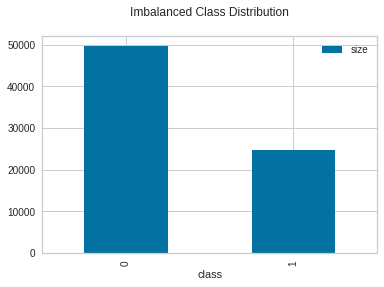

In [ ]:
df_counter.pivot_table(index='class').plot(kind='bar', title='Imbalanced Class Distribution\n')

In [ ]:
over = SMOTE()
X_balanced, y_balanced = over.fit_resample(X, y)

counter = Counter(y_balanced)
print(counter)

Counter({0: 49650, 1: 49650})


In [ ]:
dict_c = {'class': counter.keys(), 'size': counter.values()}
df_counter = pd.DataFrame(dict_c, index=range(0,2))

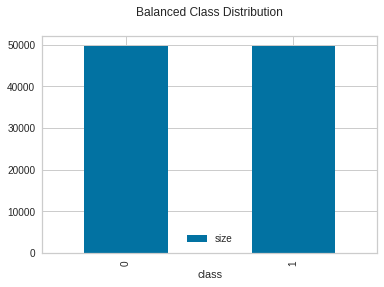

In [ ]:
df_counter.pivot_table(index='class').plot(kind='bar', title='Balanced Class Distribution\n')

In [ ]:
# concat X data and y data for pycaret
train_data = pd.concat([X_balanced, y_balanced], axis=1)
print(train_data.shape)
train_data.head()

(99300, 515)


SK_ID_CURR  CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  CNT_CHILDREN  \
0      333721            0             1                0             1   
1      110157            1             0                0             0   
2      276815            1             1                0             1   
3      353213            1             1                1             0   
4      447111            1             0                1             0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY_x  AMT_GOODS_PRICE  \
0         292500.00  1102500.00       32364.00       1102500.00   
1         270000.00   720000.00       36000.00        720000.00   
2         135000.00   360000.00       18000.00        360000.00   
3          90000.00   225000.00       10426.50        225000.00   
4         283500.00  1800000.00       51718.50       1800000.00   

   REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  \
0                        0.02      -11763           -688            -500.00   
1                        0.05      -23199         365243           -4264.00   
2                        0.01      -19165          -3432           -4524.00   
3                        0.02      -10416          -1154           -4766.00   
4                        0.00      -12125          -3256           -1913.00   

   DAYS_ID_PUBLISH  OWN_CAR_AGE  FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  \
0            -3325         9.00           1               1                0   
1            -4151         0.00           1               0                0   
2            -2558         7.00           1               1                0   
3            -3037         7.00           1               1                0   
4            -4286         0.00           1               1                0   

   FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL  CNT_FAM_MEMBERS  \
0                 1           1           0             3.00   
1                 1           0           0             2.00   
2                 1           0           1             2.00   
3                 1           1           0             1.00   
4                 1           0           0             2.00   

   REGION_RATING_CLIENT  REGION_RATING_CLIENT_W_CITY  HOUR_APPR_PROCESS_START  \
0                     3                            3                        9   
1                     1                            1                       10   
2                     2                            2                       13   
3                     2                            2                       18   
4                     1                            1                       10   

   REG_REGION_NOT_LIVE_REGION  REG_REGION_NOT_WORK_REGION  \
0                           0                           0   
1                           0                           0   
2                           0                           0   
3                           0                           0   
4                           0                           0   

   LIVE_REGION_NOT_WORK_REGION  REG_CITY_NOT_LIVE_CITY  \
0                            0                       0   
1                            0                       0   
2                            0                       0   
3                            0                       0   
4                            0                       0   

   REG_CITY_NOT_WORK_CITY  LIVE_CITY_NOT_WORK_CITY  EXT_SOURCE_1  \
0                       0                        0          0.00   
1                       0                        0          0.00   
2                       0                        0          0.81   
3                       1                        1          0.57   
4                       0                        0          0.45   

   EXT_SOURCE_2  EXT_SOURCE_3  APARTMENTS_AVG  BASEMENTAREA_AVG  \
0          0.62          0.65            0.29              0.20   
1          0.73          0.64            0.08              0.0

In [ ]:
len(df[df['TARGET'].isna()])

48744

# 3. Dimensionnal reduction with PCA 

In [ ]:
def reduce_dimensions_umap(df):
  scaler=MinMaxScaler()
  scaled = scaler.fit_transform(df)
  df_scaled = pd.DataFrame(scaled, columns=df.columns)

  reducer = umap.UMAP()
  embedding = reducer.fit_transform(df_scaled)
  return embedding
 
# reduce dimensions via pca
def reduce_dimensions_pca(df, num_features): # pca input that doesn't contain ID nor target
    #df_x = df.drop(columns=['SK_ID_CURR', 'TARGET'])
    scaler=MinMaxScaler()
    scaled = scaler.fit_transform(df)
    df_scaled = pd.DataFrame(scaled, columns=df.columns)

    num_features = min(num_features, df.shape[1])
    pca = PCA(n_components=num_features)
    pca = pca.fit(df_scaled.values)
    pca_result = pca.transform(df_scaled.values)
    print("Explained variation per principal component: ",
          np.sum(pca.explained_variance_ratio_), pca_result.shape)
    print(" > PCA Complete ===========", df.shape)
    return pca, pca_result

# 4. Feature selection

## Features selection - ANOVA - Linear Correlation

In [ ]:
scaler = MinMaxScaler()

In [ ]:
print(len(df_train.columns), len(df.columns))

515 515


In [ ]:
# ANOVA feature selection which is for numerical input and categorical output
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

In [ ]:
def anova_selection(data, n_samples, k): # function for applying on df_train with target added (only ID excluded)
  data = data.drop(columns= 'SK_ID_CURR')
  data_sample = data.sample(n= n_samples) # extract randomly n_samples lines for speeding ANOVA filtering

  X = data_sample[data_sample.columns[data_sample.columns != 'TARGET']]
  X_scaled= scaler.fit_transform(X)
  X_scaled = pd.DataFrame(X_scaled, columns= X.columns)
  y = data_sample['TARGET']
  #print(f'df sample shape: {data_sample.shape}, scaled df sample shape: {df_scaled.shape}')
  # Define features selection
  anova_selector = SelectKBest(score_func = f_classif, k= k) 
  # Apply features selection
  anova_selector.fit_transform(X_scaled, y)

  feat_names = anova_selector.get_feature_names_out()
  # Look at scores returned from the selector for each feature
  anova_scores = pd.DataFrame(list(zip(feat_names, anova_selector.scores_, anova_selector.pvalues_)), columns=['features', 'score', 'pval'])
  anova_scores.sort_values(by='score',ascending=False, inplace=True)
  return anova_scores

In [ ]:
def return_anova_features(table):
  table = table[table['pval'].values <= 0.05]
  print(len(table))
  return table

In [ ]:
scores = anova_selection(df_train, n_samples=len(df_train), k='all') # the input data will be scaled for calculation in function

In [ ]:
selected = return_anova_features(scores[0:95]) # returns 84 features dependants
selected.head()

95


features   score  pval
31   EXT_SOURCE_2 7978.83  0.00
32   EXT_SOURCE_3 4460.37  0.00
241   DAYS_CREDIT 2183.13  0.00
9      DAYS_BIRTH 1893.98  0.00
107           AGE 1893.73  0.00

## Extract avova features data from df table

In [ ]:
feat_anova = selected['features']
df_anova = df[df.columns[df.columns.isin(feat_anova)]] # df_anova is df with only anova selected features for pca analysis
#print(df_anova.describe())
print(df_anova.shape)

(356255, 95)


In [ ]:
df_anova = pd.concat([df_anova, df.iloc[:, :2]], axis=1)
df_anova.head(1)

CODE_GENDER  AMT_GOODS_PRICE  REGION_POPULATION_RELATIVE  DAYS_BIRTH  \
0            0        351000.00                        0.02       -9461   

   DAYS_EMPLOYED  DAYS_REGISTRATION  DAYS_ID_PUBLISH  FLAG_EMP_PHONE  \
0           -637           -3648.00            -2120               1   

   REGION_RATING_CLIENT  REGION_RATING_CLIENT_W_CITY  REG_CITY_NOT_LIVE_CITY  \
0                     2                            2                       0   

   REG_CITY_NOT_WORK_CITY  EXT_SOURCE_1  EXT_SOURCE_2  EXT_SOURCE_3  \
0                       0          0.08          0.26          0.14   

   APARTMENTS_AVG  BASEMENTAREA_AVG  YEARS_BEGINEXPLUATATION_AVG  \
0            0.02              0.04                         0.97   

   YEARS_BUILD_AVG  ELEVATORS_AVG  ENTRANCES_AVG  FLOORSMAX_AVG  \
0             0.62           0.00           0.07           0.08   

   FLOORSMIN_AVG  LIVINGAREA_AVG  APARTMENTS_MODE  \
0           0.12            0.02             0.03   

   YEARS_BEGINEXPLUATATION_MODE  ELEVATORS_MODE  ENTRANCES_MODE  \
0                          0.97            0.00            0.07   

   FLOORSMAX_MODE  FLOORSMIN_MODE  LIVINGAREA_MODE  APARTMENTS_MEDI  \
0            0.08            0.12             0.02             0.03   

   BASEMENTAREA_MEDI  YEARS_BEGINEXPLUATATION_MEDI  YEARS_BUILD_MEDI  \
0               0.04                          0.97              0.62   

   ELEVATORS_MEDI  ENTRANCES_MEDI  FLOORSMAX_MEDI  FLOORSMIN_MEDI  \
0            0.00            0.07            0.08            0.12   

   LIVINGAREA_MEDI  TOTALAREA_MODE  DAYS_LAST_PHONE_CHANGE  FLAG_DOCUMENT_3  \
0             0.02            0.01                -1134.00                1   

   AGE  NAME_INCOME_TYPE_Pensioner  NAME_INCOME_TYPE_Working  \
0   25                           0                         1   

   NAME_EDUCATION_TYPE_Higher education  \
0                                     0   

   NAME_EDUCATION_TYPE_Secondary / secondary special  \
0                                                  1   

   OCCUPATION_TYPE_Laborers  ORGANIZATION_TYPE_XNA  \
0                         1                      0   

   HOUSETYPE_MODE_block of flats  WALLSMATERIAL_MODE_Panel  \
0                              1                         0   

   EMERGENCYSTATE_MODE_No  DAYS_CREDIT  DAYS_CREDIT_ENDDATE  \
0                       1      -874.00              -349.00   

   DAYS_ENDDATE_FACT  DAYS_CREDIT_UPDATE  CREDIT_ACTIVE_Active  \
0            -697.50             -499.88                  0.25   

   CREDIT_ACTIVE_Closed  CREDIT_TYPE_Consumer credit  CREDIT_TYPE_Microloan  \
0                  0.75                         0.50                   0.00   

   CC_AMT_BALANCE  CC_AMT_DRAWINGS_ATM_CURRENT  CC_AMT_DRAWINGS_CURRENT  \
0            0.00                         0.00                     0.00   

   CC_AMT_INST_MIN_REGULARITY  CC_AMT_RECEIVABLE_PRINCIPAL  CC_AMT_RECIVABLE  \
0                        0.00                         0.00              0.00   

   CC_AMT_TOTAL_RECEIVABLE  CC_CNT_DRAWINGS_ATM_CURRENT  \
0                     0.00                         0.00   

   CC_CNT_DRAWINGS_CURRENT  CC_CNT_DRAWINGS_POS_CURRENT  INS_D_A  INS_D_A.1  \
0                     0.00                         0.00  -295.00    -315.42   

   POSCASH_CNT_INSTALMENT_FUTURE_MEAN  PREV_AMT_ANNUITY_SUM  \
0                               15.00               9251.77   

   PREV_DAYS_DECISION_MIN  PREV_DAYS_DECISION_MAX  PREV_DAYS_DECISION_MEAN  \
0                 -606.00                 -606.00                  -606.00   

   PREV_NAME_CONTRACT_TYPE_Revolving loans_MEAN  \
0                                          0.00   

   PREV_NAME_CONTRACT_STATUS_Approved_MEAN  \
0                                     1.00   

   PREV_NAME_CONTRACT_STATUS_Refused_MEAN  PREV_NAME_PAYMENT_TYPE_XNA_MEAN  \
0                                    0.00                             1.00   

   PREV_CODE_REJECT_REASON_HC_MEAN  PREV_CODE_REJECT_REASON_LIMIT_MEAN  \
0                   

In [ ]:
train_data = train_data.loc[:, df_anova.columns]
train_data.shape

(99300, 97)

In [ ]:
train_data.head()

CODE_GENDER  AMT_GOODS_PRICE  REGION_POPULATION_RELATIVE  DAYS_BIRTH  \
0            0       1102500.00                        0.02      -11763   
1            1        720000.00                        0.05      -23199   
2            1        360000.00                        0.01      -19165   
3            1        225000.00                        0.02      -10416   
4            1       1800000.00                        0.00      -12125   

   DAYS_EMPLOYED  DAYS_REGISTRATION  DAYS_ID_PUBLISH  FLAG_EMP_PHONE  \
0           -688            -500.00            -3325               1   
1         365243           -4264.00            -4151               0   
2          -3432           -4524.00            -2558               1   
3          -1154           -4766.00            -3037               1   
4          -3256           -1913.00            -4286               1   

   REGION_RATING_CLIENT  REGION_RATING_CLIENT_W_CITY  REG_CITY_NOT_LIVE_CITY  \
0                     3                            3                       0   
1                     1                            1                       0   
2                     2                            2                       0   
3                     2                            2                       0   
4                     1                            1                       0   

   REG_CITY_NOT_WORK_CITY  EXT_SOURCE_1  EXT_SOURCE_2  EXT_SOURCE_3  \
0                       0          0.00          0.62          0.65   
1                       0          0.00          0.73          0.64   
2                       0          0.81          0.67          0.11   
3                       1          0.57          0.30          0.19   
4                       0          0.45          0.66          0.44   

   APARTMENTS_AVG  BASEMENTAREA_AVG  YEARS_BEGINEXPLUATATION_AVG  \
0            0.29              0.20                         0.99   
1            0.08              0.06                         0.98   
2            0.24              0.17                         0.99   
3            0.00              0.00                         0.00   
4            0.00              0.00                         0.00   

   YEARS_BUILD_AVG  ELEVATORS_AVG  ENTRANCES_AVG  FLOORSMAX_AVG  \
0             0.00           0.28           0.24           0.38   
1             0.69           0.02           0.12           0.19   
2             0.89           0.24           0.21           0.38   
3             0.00           0.00           0.00           0.00   
4             0.00           0.00           0.00           0.00   

   FLOORSMIN_AVG  LIVINGAREA_AVG  APARTMENTS_MODE  \
0           0.00            0.06             0.30   
1           0.23            0.07             0.08   
2           0.42            0.26             0.24   
3           0.00            0.00             0.00   
4           0.00            0.00             0.00   

   YEARS_BEGINEXPLUATATION_MODE  ELEVATORS_MODE  ENTRANCES_MODE  \
0                          0.99            0.28            0.24   
1                          0.98            0.00            0.14   
2                          0.99            0.24            0.21   
3                          0.00            0.00            0.00   
4                          0.00            0.00            0.00   

   FLOORSMAX_MODE  FLOORSMIN_MODE  LIVINGAREA_MODE  APARTMENTS_MEDI  \
0            0.38            0.00             0.07             0.30   
1            0.17            0.21             0.05             0.08   
2            0.38            0.42             0.27             0.24   
3            0.00            0.00             0.00             0.00   
4            0.00            0.00             0.00             0.00   

   BASEMENTAREA_MEDI  YEARS_BEGINEXPLUATATION_MEDI  YEARS_BUILD_MEDI  \
0               0.20                          0.99              0.00   
1               0.07                          0.98              0.67   
2               0.17              

###PCA reduce linear dimensions

In [ ]:
pca, x_pca = reduce_dimensions_pca(df_anova, 35)

Explained variation per principal component:  0.9657912968057638 (356255, 35)
 > PCA Complete =========== (356255, 95)


In [ ]:
print(len(x_pca), len(x_pca[0]))

356255 60


In [ ]:
df_pca = pd.DataFrame(x_pca, columns=range(len(x_pca[0])), index= range(len(x_pca)))

In [ ]:
df_pca.head()

0     1     2     3     4     5     6     7     8     9     10    11  \
0  0.86 -0.73 -0.69  0.13 -0.14 -0.27 -0.48 -0.11  0.29 -0.01 -0.29  1.06   
1  1.23 -0.25  0.93 -0.44 -0.02  0.50  0.09 -0.35 -0.19 -0.02 -0.41  0.39   
2 -1.21 -0.28 -0.48 -0.74 -0.05 -1.07 -0.23  0.56 -0.29 -0.14  0.26  0.63   
3 -1.21 -0.43 -0.40  1.03 -0.17  0.34 -0.56  0.20 -0.16  0.12  0.31  0.74   
4 -1.31 -0.25 -0.39 -0.36  0.04 -0.54  0.42  0.76  0.15  0.25 -0.27 -0.23   

     12    13    14    15    16    17    18    19    20    21    22    23  \
0 -0.09  0.14  0.18 -0.04 -0.74  0.06  0.31 -0.15 -0.13  0.17  0.13  0.11   
1 -0.30  0.30 -0.23 -0.16 -0.10  0.14  0.10 -0.05 -0.14 -0.39  0.14  0.10   
2 -0.07 -0.33 -0.19 -0.04 -0.10 -0.25 -0.03  0.37  0.20 -0.04  0.07  0.09   
3 -0.37  0.04 -0.14 -0.03  0.16 -0.19  0.04  0.22  0.20 -0.31 -0.10 -0.17   
4 -0.48 -0.07 -0.10 -0.36  0.52  0.03  0.09  0.12 -0.52 -0.22  0.47  0.12   

     24    25    26    27    28    29    30    31    32    33    34    35  \
0 -0.48 -0.08  0.48 -0.11  0.28  0.16 -0.18 -0.08 -0.08 -0.08  0.02  0.14   
1 -0.12 -0.21  0.02 -0.28  0.35 -0.20 -0.20  0.29  0.07 -0.20  0.35 -0.09   
2  0.32 -0.12 -0.35  0.03 -0.24  0.02 -0.24  0.26  0.10 -0.05  0.03  0.13   
3 -0.04 -0.06  0.10 -0.01 -0.11 -0.04  0.10  0.02 -0.04  0.00  0.13 -0.20   
4 -0.06  0.07 -0.06  0.03  0.10 -0.02 -0.09 -0.03 -0.00 -0.01 -0.04  0.11   

     36    37    38    39    40    41    42    43    44    45    46    47  \
0 -0.06  0.03  0.03 -0.09 -0.04 -0.17 -0.01 -0.05  0.06 -0.09  0.09 -0.05   
1  0.20 -0.03 -0.01  0.03  0.06 -0.21 -0.11  0.07  0.01  0.10  0.06  0.16   
2  0.07 -0.02  0.03  0.03 -0.08 -0.05 -0.05 -0.03 -0.11 -0.03  0.00  0.04   
3 -0.08 -0.03 -0.11 -0.08  0.10 -0.01 -0.02  0.12 -0.09  0.01 -0.00  0.04   
4  0.05 -0.00  0.04  0.02  0.00 -0.18  0.03 -0.06 -0.08  0.03 -0.01 -0.07   

     48    49    50    51    52    53    54    55    56    57    58    59  
0  0.09  0.01  0.02  0.01 -0.01  0.00  0.03 -0.03  0.00  0.03 -0.01 -0.00  
1 -0.08  0.03  0.03  0.01  0.01  0.05 -0.01 -0.00 -0.01  0.02  0.01 -0.00  
2 -0.01 -0.05  0.00  0.00  0.00 -0.00 -0.04  0.00 -0.02  0.00  0.00  0.01  
3 -0.02  0.03  0.00  0.00 -0.02 -0.00 -0.02  0.01  0.00 -0.00  0.00 -0.00  
4  0.03 -0.01 -0.00 -0.00  0.00 -0.00  0.02 -0.03 -0.02 -0.00 -0.00  0.01

In [ ]:
df_pca.index

RangeIndex(start=0, stop=356255, step=1)

### Principle composants explaination

In [ ]:
from matplotlib.collections import LineCollection

In [ ]:
def display_circles(pcs, n_comp, pca, axis_ranks, labels=None, label_rotation=30, lims=None):
    for d1, d2 in axis_ranks: # On affiche les 3 premiers plans factoriels, donc les 6 premières composantes
        if d2 < n_comp:

            # initialisation de la figure
            fig, ax = plt.subplots(figsize=(15,9))

            # détermination des limites du graphique
            if lims is not None :
                xmin, xmax, ymin, ymax = lims
            elif pcs.shape[1] < 30 :
                xmin, xmax, ymin, ymax = -1, 1, -1, 1
            else :
                xmin, xmax, ymin, ymax = min(pcs[d1,:]), max(pcs[d1,:]), min(pcs[d2,:]), max(pcs[d2,:])

            # affichage des flèches
            # s'il y a plus de 30 flèches, on n'affiche pas le triangle à leur extrémité
            if pcs.shape[1] < 30 :
                plt.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]),
                   pcs[d1,:], pcs[d2,:], 
                   angles='xy', scale_units='xy', scale=1, color="grey")
                  # (voir la doc : https://matplotlib.org/api/_as_gen/matplotlib.pyplot.quiver.html)
                
            else:
                lines = [[[0,0],[x,y]] for x,y in pcs[[d1,d2]].T]
                ax.add_collection(LineCollection(lines, axes=ax, alpha=.5, color='black'))
            
             # affichage des noms des variables  

            for i,(x, y) in enumerate(pcs[[d1,d2]].T):
              if x >= xmin and x <= xmax and y >= ymin and y <= ymax :
                  plt.text(x, y, labels[i], fontsize='11', ha='right', va='top', rotation=label_rotation, color="blue", alpha=0.75)

            
            # affichage du cercle
            circle = plt.Circle((0,0), 1, facecolor='none', edgecolor='b')
            plt.gca().add_artist(circle)

            # définition des limites du graphique
            plt.xlim(xmin, xmax)
            plt.ylim(ymin, ymax)
        
            # affichage des lignes horizontales et verticales
            plt.plot([-1, 1], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-1, 1], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Cercle des corrélations (F{} et F{})".format(d1+1, d2+1))
            plt.show(block=False)

In [ ]:
display_circles(pcs=pca.components_, n_comp= 30, pca=pca, axis_ranks=[(0,1),(2,3),(4,5)], labels = np.array(df_anova.columns))


## Features correlation check

In [ ]:
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.ensemble import ExtraTreesClassifier
from lightgbm import LGBMClassifier
#sklearn.metrics.SCORERS.keys()

In [ ]:
train_features = train_data.drop(columns=['SK_ID_CURR', 'TARGET']).columns
train_data_X = train_data[train_data.columns[train_data.columns.isin(train_features)]]
train_data_X.shape

(99300, 95)

In [ ]:
test_data = df_test[df_test.columns[df_test.columns.isin(train_data.columns)]]

In [ ]:
test_data.shape

(48744, 97)

In [ ]:
test_data_X = df_test[df_test.columns[df_test.columns.isin(train_data_X.columns)]]
test_data_X.shape

(48744, 95)

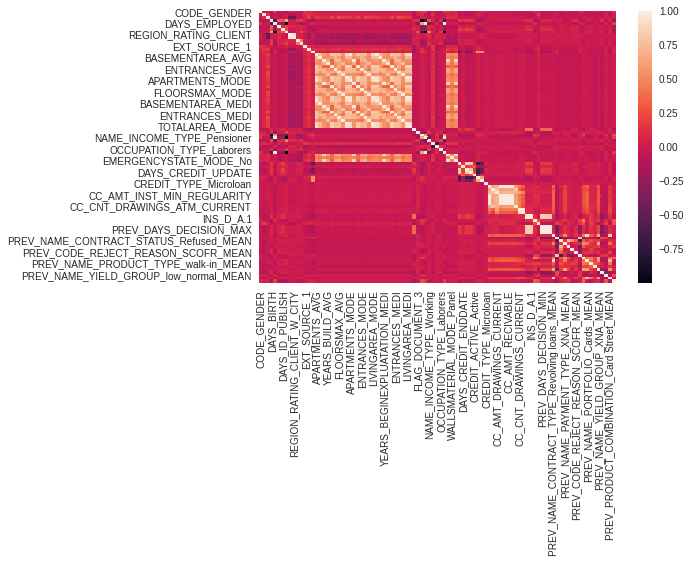

In [ ]:
# figure size
figure, ax = plt.subplots(figsize=(8, 5))
# correlation plot to find correlations between variables
corr = train_data.corr()
# plot the correlation
sns.heatmap(corr, ax= ax)

# Pycaret training and prediction

## Training

In [ ]:
#train_data =pd.read_csv("/gdrive/MyDrive/P7dataset/kendall_balanced_train.csv")
print(train_data.shape)
train_data.head()

(99300, 97)


CODE_GENDER  AMT_GOODS_PRICE  REGION_POPULATION_RELATIVE  DAYS_BIRTH  \
0            0       1102500.00                        0.02      -11763   
1            1        720000.00                        0.05      -23199   
2            1        360000.00                        0.01      -19165   
3            1        225000.00                        0.02      -10416   
4            1       1800000.00                        0.00      -12125   

   DAYS_EMPLOYED  DAYS_REGISTRATION  DAYS_ID_PUBLISH  FLAG_EMP_PHONE  \
0           -688            -500.00            -3325               1   
1         365243           -4264.00            -4151               0   
2          -3432           -4524.00            -2558               1   
3          -1154           -4766.00            -3037               1   
4          -3256           -1913.00            -4286               1   

   REGION_RATING_CLIENT  REGION_RATING_CLIENT_W_CITY  REG_CITY_NOT_LIVE_CITY  \
0                     3                            3                       0   
1                     1                            1                       0   
2                     2                            2                       0   
3                     2                            2                       0   
4                     1                            1                       0   

   REG_CITY_NOT_WORK_CITY  EXT_SOURCE_1  EXT_SOURCE_2  EXT_SOURCE_3  \
0                       0          0.00          0.62          0.65   
1                       0          0.00          0.73          0.64   
2                       0          0.81          0.67          0.11   
3                       1          0.57          0.30          0.19   
4                       0          0.45          0.66          0.44   

   APARTMENTS_AVG  BASEMENTAREA_AVG  YEARS_BEGINEXPLUATATION_AVG  \
0            0.29              0.20                         0.99   
1            0.08              0.06                         0.98   
2            0.24              0.17                         0.99   
3            0.00              0.00                         0.00   
4            0.00              0.00                         0.00   

   YEARS_BUILD_AVG  ELEVATORS_AVG  ENTRANCES_AVG  FLOORSMAX_AVG  \
0             0.00           0.28           0.24           0.38   
1             0.69           0.02           0.12           0.19   
2             0.89           0.24           0.21           0.38   
3             0.00           0.00           0.00           0.00   
4             0.00           0.00           0.00           0.00   

   FLOORSMIN_AVG  LIVINGAREA_AVG  APARTMENTS_MODE  \
0           0.00            0.06             0.30   
1           0.23            0.07             0.08   
2           0.42            0.26             0.24   
3           0.00            0.00             0.00   
4           0.00            0.00             0.00   

   YEARS_BEGINEXPLUATATION_MODE  ELEVATORS_MODE  ENTRANCES_MODE  \
0                          0.99            0.28            0.24   
1                          0.98            0.00            0.14   
2                          0.99            0.24            0.21   
3                          0.00            0.00            0.00   
4                          0.00            0.00            0.00   

   FLOORSMAX_MODE  FLOORSMIN_MODE  LIVINGAREA_MODE  APARTMENTS_MEDI  \
0            0.38            0.00             0.07             0.30   
1            0.17            0.21             0.05             0.08   
2            0.38            0.42             0.27             0.24   
3            0.00            0.00             0.00             0.00   
4            0.00            0.00             0.00             0.00   

   BASEMENTAREA_MEDI  YEARS_BEGINEXPLUATATION_MEDI  YEARS_BUILD_MEDI  \
0               0.20                          0.99              0.00   
1               0.07                          0.98              0.67   
2               0.17              

In [ ]:
#kendal_test = pd.read_csv("/gdrive/MyDrive/P7dataset/kendall_test.csv")
print(test_data_X.shape)
test_data_X.head()

(48744, 95)


CODE_GENDER  AMT_GOODS_PRICE  REGION_POPULATION_RELATIVE  DAYS_BIRTH  \
307511            1        450000.00                        0.02      -19241   
307512            0        180000.00                        0.04      -18064   
307513            0        630000.00                        0.02      -20038   
307514            1       1575000.00                        0.03      -13976   
307515            0        625500.00                        0.01      -13040   

        DAYS_EMPLOYED  DAYS_REGISTRATION  DAYS_ID_PUBLISH  FLAG_EMP_PHONE  \
307511          -2329           -5170.00             -812               1   
307512          -4469           -9118.00            -1623               1   
307513          -4458           -2175.00            -3503               1   
307514          -1866           -2000.00            -4208               1   
307515          -2191           -4000.00            -4262               1   

        REGION_RATING_CLIENT  REGION_RATING_CLIENT_W_CITY  \
307511                     2                            2   
307512                     2                            2   
307513                     2                            2   
307514                     2                            2   
307515                     2                            2   

        REG_CITY_NOT_LIVE_CITY  REG_CITY_NOT_WORK_CITY  EXT_SOURCE_1  \
307511                       0                       0          0.75   
307512                       0                       0          0.56   
307513                       0                       0          0.00   
307514                       0                       0          0.53   
307515                       0                       1          0.20   

        EXT_SOURCE_2  EXT_SOURCE_3  APARTMENTS_AVG  BASEMENTAREA_AVG  \
307511          0.79          0.16            0.07              0.06   
307512          0.29          0.43            0.00              0.00   
307513          0.70          0.61            0.00              0.00   
307514          0.51          0.61            0.31              0.20   
307515          0.43          0.00            0.00              0.00   

        YEARS_BEGINEXPLUATATION_AVG  YEARS_BUILD_AVG  ELEVATORS_AVG  \
307511                         0.97             0.00           0.00   
307512                         0.00             0.00           0.00   
307513                         0.00             0.00           0.00   
307514                         1.00             0.96           0.32   
307515                         0.00             0.00           0.00   

        ENTRANCES_AVG  FLOORSMAX_AVG  FLOORSMIN_AVG  LIVINGAREA_AVG  \
307511           0.14           0.12           0.00            0.05   
307512           0.00           0.00           0.00            0.00   
307513           0.00           0.00           0.00            0.00   
307514           0.28           0.38           0.04            0.37   
307515           0.00           0.00           0.00            0.00   

        APARTMENTS_MODE  YEARS_BEGINEXPLUATATION_MODE  ELEVATORS_MODE  \
307511             0.07                          0.97            0.00   
307512             0.00                          0.00            0.00   
307513             0.00                          0.00            0.00   
307514             0.31                          1.00            0.32   
307515             0.00                          0.00            0.00   

        ENTRANCES_MODE  FLOORSMAX_MODE  FLOORSMIN_MODE  LIVINGAREA_MODE  \
307511            0.14            0.12            0.00             0.05   
307512            0.00            0.00            0.00             0.00   
307513            0.00            0.00            0.00             0.00   
307514            0.28            0.38            0.04             0.38   
307515            0.00            0.00            0.00             0.00   

        APARTMENTS_MEDI  BASEMENTAREA_MEDI  YEARS_BEGINEXPLUATATION_MEDI  \
307511     

In [ ]:
# set up the dataset
grid = setup(data = train_data_X, target=train_data['TARGET'], html=False, verbose=True)

                    Description             Value
0                    Session id              3162
1                        Target            TARGET
2                   Target type            Binary
3           Original data shape       (99300, 96)
4        Transformed data shape       (99300, 96)
5   Transformed train set shape       (69510, 96)
6    Transformed test set shape       (29790, 96)
7              Numeric features                95
8                    Preprocess              True
9               Imputation type            simple
10           Numeric imputation              mean
11       Categorical imputation              mode
12               Fold Generator   StratifiedKFold
13                  Fold Number                10
14                     CPU Jobs                -1
15                      Use GPU             False
16               Log Experiment             False
17              Experiment Name  clf-default-name
18                          USI              d793


In [ ]:
# compare models
best = compare_models()

                                    Model  Accuracy  AUC  Recall  Prec.   F1  \
lightgbm  Light Gradient Boosting Machine      0.79 0.87    0.74   0.82 0.78   
et                 Extra Trees Classifier      0.78 0.86    0.72   0.81 0.76   
rf               Random Forest Classifier      0.78 0.86    0.71   0.82 0.76   
gbc          Gradient Boosting Classifier      0.77 0.86    0.74   0.79 0.77   
ada                  Ada Boost Classifier      0.76 0.84    0.74   0.76 0.75   
ridge                    Ridge Classifier      0.75 0.00    0.72   0.77 0.74   
lda          Linear Discriminant Analysis      0.75 0.83    0.72   0.77 0.74   
dt               Decision Tree Classifier      0.68 0.68    0.68   0.67 0.68   
knn                K Neighbors Classifier      0.61 0.65    0.65   0.61 0.63   
nb                            Naive Bayes      0.60 0.64    0.49   0.63 0.55   
lr                    Logistic Regression      0.58 0.62    0.52   0.60 0.55   
qda       Quadratic Discriminant Analysi

In [ ]:
print(best) # get the best model hyperparameters

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=3162, reg_alpha=0.0, reg_lambda=0.0, silent='warn',
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)


In [ ]:
light_gbm = create_model(best)


Processing: 100%|██████████| 4/4 [00:40<00:00,  9.97s/it]
                                                         

      Accuracy  AUC  Recall  Prec.   F1  Kappa  MCC
Fold                                               
0         0.79 0.87    0.74   0.82 0.78   0.57 0.58
1         0.79 0.87    0.74   0.83 0.78   0.58 0.59
2         0.79 0.87    0.74   0.83 0.78   0.58 0.58
3         0.78 0.87    0.74   0.81 0.77   0.57 0.57
4         0.79 0.88    0.74   0.82 0.78   0.58 0.59
5         0.78 0.87    0.73   0.81 0.77   0.56 0.57
6         0.79 0.87    0.74   0.82 0.78   0.57 0.57
7         0.78 0.87    0.73   0.81 0.77   0.56 0.56
8         0.79 0.87    0.74   0.82 0.78   0.57 0.58
9         0.79 0.88    0.74   0.83 0.78   0.59 0.59
Mean      0.79 0.87    0.74   0.82 0.78   0.57 0.58
Std       0.00 0.00    0.00   0.01 0.00   0.01 0.01


In [ ]:
# model parameter tunning
tuned_model = tune_model(light_gbm)


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits



Processing: 100%|██████████| 7/7 [06:44<00:00, 45.47s/it]
                                                         

      Accuracy  AUC  Recall  Prec.   F1  Kappa  MCC
Fold                                               
0         0.79 0.88    0.74   0.82 0.78   0.58 0.58
1         0.80 0.88    0.74   0.83 0.78   0.59 0.59
2         0.79 0.87    0.73   0.83 0.78   0.58 0.59
3         0.78 0.87    0.73   0.81 0.77   0.56 0.57
4         0.79 0.88    0.74   0.83 0.78   0.58 0.59
5         0.79 0.87    0.73   0.82 0.77   0.57 0.58
6         0.79 0.88    0.74   0.82 0.78   0.57 0.58
7         0.78 0.87    0.73   0.82 0.77   0.57 0.57
8         0.79 0.87    0.74   0.82 0.78   0.58 0.58
9         0.79 0.88    0.73   0.83 0.78   0.59 0.59
Mean      0.79 0.87    0.74   0.82 0.78   0.58 0.58
Std       0.00 0.00    0.01   0.01 0.00   0.01 0.01


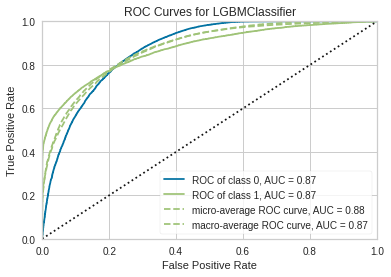

In [ ]:
# evaluate model
plot_model(tuned_model, plot= 'auc')

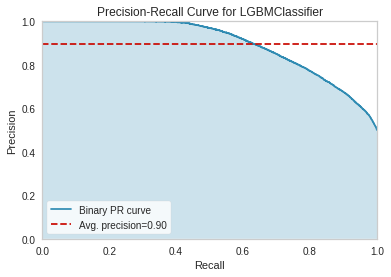

In [ ]:
# evaluate model
plot_model(tuned_model, plot= 'pr')

In [ ]:
optimize_threshold(light_gbm)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=3162, reg_alpha=0.0, reg_lambda=0.0, silent='warn',
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

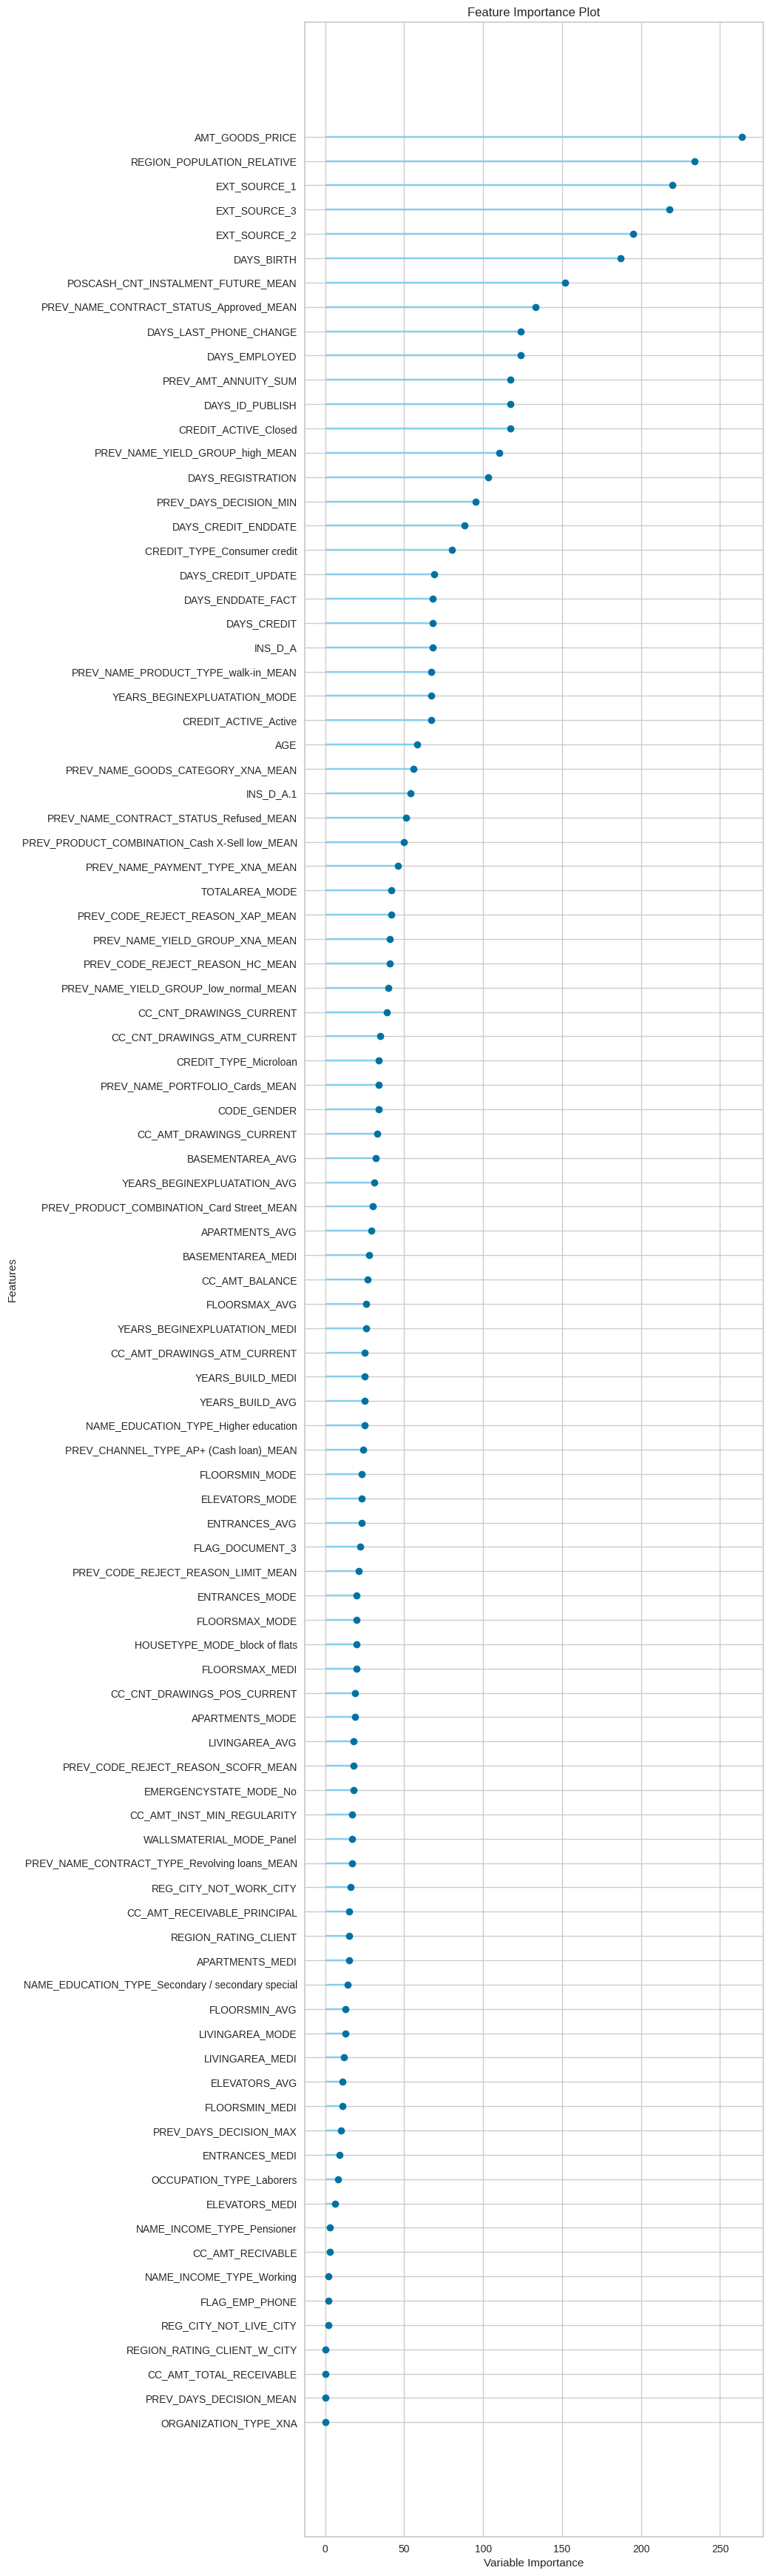

In [ ]:
# feature importance plot
plot_model(tuned_model, plot= 'feature_all')

In [ ]:
# use function finalize_model for fitting the model onto the complete dataset before the deployment in production
final_model = finalize_model(tuned_model)

In [ ]:
print(final_model) # model parameters for deployment

Pipeline(memory=Memory(location=/tmp/joblib),
         steps=[('clean_column_names',
                 TransformerWrapper(exclude=None, include=None,
                                    transformer=CleanColumnNames(match='[\\]\\[\\,\\{\\}\\"\\:]+'))),
                ('numerical_imputer',
                 TransformerWrapper(exclude=None,
                                    include=['CODE_GENDER', 'AMT_GOODS_PRICE',
                                             'REGION_POPULATION_RELATIVE',
                                             'DAYS_BIRTH', 'DAYS_EMPLOYED',
                                             'DAYS_REGISTRA...
                                colsample_bytree=1.0, feature_fraction=0.9,
                                importance_type='split', learning_rate=0.1,
                                max_depth=-1, min_child_samples=16,
                                min_child_weight=0.001, min_split_gain=0.9,
                                n_estimators=250, n_jobs=-1, num_leaves=

## Prediction

In [ ]:
prediction = predict_model(final_model, data= test_data_X)
prediction.head()

CODE_GENDER  AMT_GOODS_PRICE  REGION_POPULATION_RELATIVE  DAYS_BIRTH  \
0            1        450000.00                        0.02      -19241   
1            0        180000.00                        0.04      -18064   
2            0        630000.00                        0.02      -20038   
3            1       1575000.00                        0.03      -13976   
4            0        625500.00                        0.01      -13040   

   DAYS_EMPLOYED  DAYS_REGISTRATION  DAYS_ID_PUBLISH  FLAG_EMP_PHONE  \
0          -2329           -5170.00             -812               1   
1          -4469           -9118.00            -1623               1   
2          -4458           -2175.00            -3503               1   
3          -1866           -2000.00            -4208               1   
4          -2191           -4000.00            -4262               1   

   REGION_RATING_CLIENT  REGION_RATING_CLIENT_W_CITY  ...  \
0                     2                            2  ...   
1                     2                            2  ...   
2                     2                            2  ...   
3                     2                            2  ...   
4                     2                            2  ...   

   PREV_NAME_PORTFOLIO_Cards_MEAN  PREV_NAME_PRODUCT_TYPE_walk-in_MEAN  \
0                            0.00                                 0.00   
1                            0.00                                 0.00   
2                            0.00                                 0.00   
3                            0.20                                 0.00   
4                            0.00                                 0.00   

   PREV_CHANNEL_TYPE_AP+ (Cash loan)_MEAN  PREV_NAME_YIELD_GROUP_XNA_MEAN  \
0                                    0.00                            0.00   
1                                    0.00                            0.50   
2                                    0.00                            0.25   
3                                    0.00                            0.60   
4                                    0.00                            0.00   

   PREV_NAME_YIELD_GROUP_high_MEAN  PREV_NAME_YIELD_GROUP_low_normal_MEAN  \
0                             1.00                                   0.00   
1                             0.50                                   0.00   
2                             0.25                                   0.00   
3                             0.00                                   0.00   
4                             0.50                                   0.00   

   PREV_PRODUCT_COMBINATION_Card Street_MEAN  \
0                                       0.00   
1                                       0.00   
2                                       0.00   
3                                       0.00   
4                                       0.00   

   PREV_PRODUCT_COMBINATION_Cash X-Sell: low_MEAN  prediction_label  \
0                                            0.00                 0   
1                                            0.00                 1   
2                                            0.00                 0   
3                                            0.00                 0   
4                                            0.00                 1   

   prediction_score  
0              0.81  
1              0.51  
2              0.88  
3              0.82  
4              0.60  

[5 rows x 97 columns]

In [ ]:
model_name = 'BestModel'
save_model(final_model, model_name)

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=/tmp/joblib),
          steps=[('clean_column_names',
                  TransformerWrapper(exclude=None, include=None,
                                     transformer=CleanColumnNames(match='[\\]\\[\\,\\{\\}\\"\\:]+'))),
                 ('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['CODE_GENDER', 'AMT_GOODS_PRICE',
                                              'REGION_POPULATION_RELATIVE',
                                              'DAYS_BIRTH', 'DAYS_EMPLOYED',
                                              'DAYS_REGISTRA...
                                 colsample_bytree=1.0, feature_fraction=0.9,
                                 importance_type='split', learning_rate=0.1,
                                 max_depth=-1, min_child_samples=16,
                                 min_child_weight=0.001, min_split_gain=0.9,
                                 n_estimators=250, n_jobs=

In [ ]:
import pickle

In [ ]:
infile = open("/content/BestModel.pkl", 'rb')
model = pickle.load(infile)

## *Note for methodology of model training with pycaret*

In [ ]:
# https://towardsdatascience.com/build-pycaret-deploy-gcp-521415a6c330



For model training part, pycaret is an open-source, low-code machine learning library that automates machine learning workflows. It helps us to select the best model(s) and compute multiple metrics.

Among several modules provided by PyCaret, the supervised learning one correspond to classification task in this projet (pycaret.classification package is imported).

Before using PyCaret for model training, there is quite a lot of features in our dataset. We reduced variables number from 794 to 143 by ANOVA feature selection. Note that ANOVA detects variables highly dependant to target variable and compute score for each variable evaluated, but only for linear correlated varaibles. We keep only varaibles with p-value less than 0.05.

We have also increased positive target sample quantity faced on imbalanced classes distribution issue. The method used is SMOTE, the Synthetic Minority Oversampling Technique, to increase data of minority class. Here, we increased it to a half of the majority class.

Once the dataset is prepared, we make classification model training in PyCaret on the **train data **for evaluating model performances.

  - setup() function allows to input data and target data. It contains also many other parameters which make ETL transformations and EDA for outliers, missing values... we have our data cleaned so we're not in this case. 
  - compare_models function is for model training. It trains all algorithmes that is available in the model zoo, and evaluate models automatically by multiple metrics using k-fold cross-validation. In classification module, metrics computed are: Accuracy, AUC, Recall, Precesion, F1-score, Kappa, MCC and train time. Number of folds for cross-validation is 10 by default. The final score of each metric will be the average score of validation tests. 

Theses are 2 principle functions used for model training by Pycaret. And we get a table comparasion result on different algorithmes:

- **ExtraTreesClassifier** seems to be the most performant model by 'accuracy' metric. 

- Followed with **RandomForest**, **LightGBM, K Neighbors and GradientBoosting**.



⚾ https://pycaret.readthedocs.io/en/stable/api/classification.html ⚾

# Model training and optimization GridsearchCV

## Training

In [ ]:
train_data['TARGET'].value_counts()

0    12413
1    12413
Name: TARGET, dtype: int64

In [ ]:
train_data.to_csv("model_data_train.csv", index=False) 
!cp model_data_train.csv "/gdrive/MyDrive/P7dataset/"
test_data.to_csv("model_data_test.csv", index=False) 
!cp model_data_test.csv "/gdrive/MyDrive/P7dataset/"

In [ ]:
train_data = pd.read_csv('/gdrive/MyDrive/P7dataset/model_data_train.csv')
test_data = pd.read_csv('/gdrive/MyDrive/P7dataset/model_data_test.csv')

In [ ]:
print(train_data.shape)
train_data.head()

(99300, 97)


SK_ID_CURR  TARGET  CODE_GENDER  AMT_GOODS_PRICE  \
0      333721       0            0       1102500.00   
1      110157       0            1        720000.00   
2      276815       0            1        360000.00   
3      353213       0            1        225000.00   
4      447111       0            1       1800000.00   

   REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  \
0                        0.02      -11763           -688            -500.00   
1                        0.05      -23199         365243           -4264.00   
2                        0.01      -19165          -3432           -4524.00   
3                        0.02      -10416          -1154           -4766.00   
4                        0.00      -12125          -3256           -1913.00   

   DAYS_ID_PUBLISH  FLAG_EMP_PHONE  ...  PREV_CODE_REJECT_REASON_XAP_MEAN  \
0            -3325               1  ...                              1.00   
1            -4151               0  ...                              0.91   
2            -2558               1  ...                              1.00   
3            -3037               1  ...                              0.50   
4            -4286               1  ...                              0.00   

   PREV_NAME_GOODS_CATEGORY_XNA_MEAN  PREV_NAME_PORTFOLIO_Cards_MEAN  \
0                               0.00                            0.00   
1                               0.82                            0.09   
2                               0.00                            0.00   
3                               0.80                            0.20   
4                               0.00                            0.00   

   PREV_NAME_PRODUCT_TYPE_walk-in_MEAN  \
0                                 0.00   
1                                 0.00   
2                                 0.00   
3                                 0.40   
4                                 0.00   

   PREV_CHANNEL_TYPE_AP+ (Cash loan)_MEAN  PREV_NAME_YIELD_GROUP_XNA_MEAN  \
0                                    0.00                            0.00   
1                                    0.00                            0.55   
2                                    0.00                            0.00   
3                                    0.00                            0.40   
4                                    0.00                            0.00   

   PREV_NAME_YIELD_GROUP_high_MEAN  PREV_NAME_YIELD_GROUP_low_normal_MEAN  \
0                             0.00                                   0.67   
1                             0.27                                   0.00   
2                             0.00                                   0.67   
3                             0.00                                   0.50   
4                             0.00                                   0.00   

   PREV_PRODUCT_COMBINATION_Card Street_MEAN  \
0                                       0.00   
1                                       0.09   
2                                       0.00   
3                                       0.10   
4                                       0.00   

   PREV_PRODUCT_COMBINATION_Cash X-Sell low_MEAN  
0                                           0.00  
1                                           0.09  
2                                           0.00  
3                                           0.00  
4                                           0.00  

[5 rows x 97 columns]

In [ ]:
# train selected tree-models 

models= [
{"name": "Extra Trees", "clf": ExtraTreesClassifier()},
{"name": "LightGBM", "clf": LGBMClassifier()},
{"name": "Random Forest", "clf": RandomForestClassifier()},
{"name": "Decision Tree", "clf": DecisionTreeClassifier()}
          ]


def train_model(model, train_data):
  X = train_data[train_data.columns[train_data.columns.isin(['TARGET', 'SK_ID_CURR']) == False]]
  y = train_data['TARGET']

  scaler = MinMaxScaler()

  X_train, X_test, y_train, y_test = train_test_split(X, y, random_state= 42) # the balanced X train data

  pipe = Pipeline([('MinMaxScaler', scaler),('clf', model["clf"])])
  start_time = time.time()
  pipe.fit(X_train, y_train)
  train_time = time.time() - start_time

  train_accuracy = pipe.score(X_train, y_train)
  test_accuracy= pipe.score(X_test, y_test) 
  model_details = {"name": model["name"], "train_accuracy":train_accuracy, "test_accuracy": test_accuracy, "train_time": train_time, "model": pipe}
  return model_details

trained_models = []
for model in models:
  trained = train_model(model, train_data)
  trained_models.append(trained)

In [ ]:
trained_models

[{'name': 'Extra Trees',
  'train_accuracy': 1.0,
  'test_accuracy': 0.7804229607250756,
  'train_time': 23.976425170898438,
  'model': Pipeline(steps=[('MinMaxScaler', MinMaxScaler()),
                  ('clf', ExtraTreesClassifier())])},
 {'name': 'LightGBM',
  'train_accuracy': 0.8076401477005707,
  'test_accuracy': 0.7895669687814703,
  'train_time': 2.926670789718628,
  'model': Pipeline(steps=[('MinMaxScaler', MinMaxScaler()), ('clf', LGBMClassifier())])},
 {'name': 'Random Forest',
  'train_accuracy': 1.0,
  'test_accuracy': 0.7785699899295065,
  'train_time': 42.406511068344116,
  'model': Pipeline(steps=[('MinMaxScaler', MinMaxScaler()),
                  ('clf', RandomForestClassifier())])},
 {'name': 'Decision Tree',
  'train_accuracy': 1.0,
  'test_accuracy': 0.6796777442094663,
  'train_time': 6.437646865844727,
  'model': Pipeline(steps=[('MinMaxScaler', MinMaxScaler()),
                  ('clf', DecisionTreeClassifier())])}]

In [ ]:
trained_models_df = pd.DataFrame(trained_models)
trained_models_df

name  train_accuracy  test_accuracy  train_time  \
0    Extra Trees            1.00           0.78       23.98   
1       LightGBM            0.81           0.79        2.93   
2  Random Forest            1.00           0.78       42.41   
3  Decision Tree            1.00           0.68        6.44   

                                                                                                                                                                                                                                                                                                         model  
0  (MinMaxScaler(), (ExtraTreeClassifier(random_state=649006103), ExtraTreeClassifier(random_state=1295215866), ExtraTreeClassifier(random_state=139995278), ExtraTreeClassifier(random_state=648989828), ExtraTreeClassifier(random_state=1489133268), ExtraTreeClassifier(random_state=1680157992), Extra...  
1                                                                                                                                                                                                                                                                           (MinMaxScaler(), LGBMClassifier())  
2  (MinMaxScaler(), (DecisionTreeClassifier(max_features='auto', random_state=544149114), DecisionTreeClassifier(max_features='auto', random_state=2065502575), DecisionTreeClassifier(max_features='auto', random_state=595908030), DecisionTreeClassifier(max_features='auto', random_state=1961705653), ...  
3                                                                                                                                                                                                                                                                   (MinMaxScaler(), DecisionTreeClassifier())

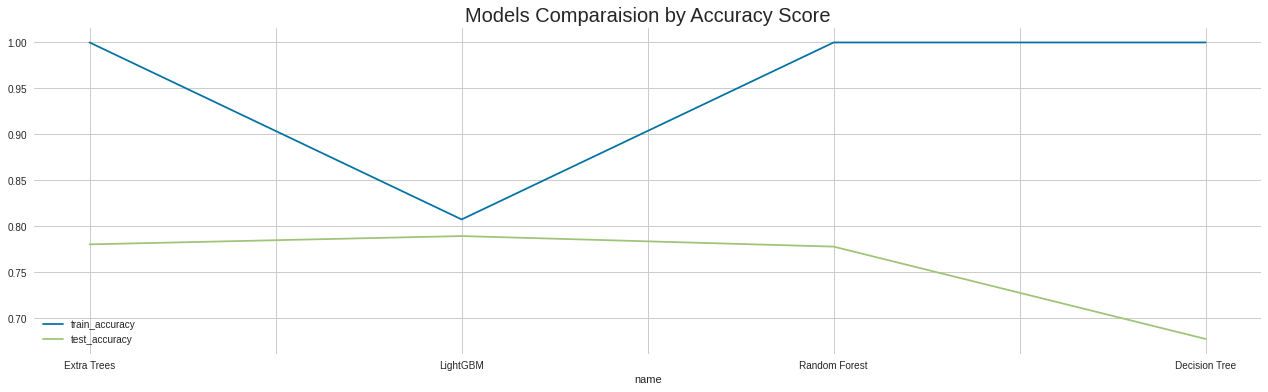

In [ ]:
models_ax = trained_models_df[["train_accuracy", "test_accuracy", "name"]].plot(kind="line", x="name", title="Models Comparaision by Accuracy Score", figsize=(22,6))
models_ax.title.set_size(20)
models_ax.legend(["train_accuracy", "test_accuracy"])
plt.box(False)

## Optimisation

In [ ]:
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

In [ ]:
train_data.head()

SK_ID_CURR  TARGET  CODE_GENDER  AMT_GOODS_PRICE  \
0      333721       0            0       1102500.00   
1      110157       0            1        720000.00   
2      276815       0            1        360000.00   
3      353213       0            1        225000.00   
4      447111       0            1       1800000.00   

   REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  \
0                        0.02      -11763           -688            -500.00   
1                        0.05      -23199         365243           -4264.00   
2                        0.01      -19165          -3432           -4524.00   
3                        0.02      -10416          -1154           -4766.00   
4                        0.00      -12125          -3256           -1913.00   

   DAYS_ID_PUBLISH  FLAG_EMP_PHONE  ...  PREV_CODE_REJECT_REASON_XAP_MEAN  \
0            -3325               1  ...                              1.00   
1            -4151               0  ...                              0.91   
2            -2558               1  ...                              1.00   
3            -3037               1  ...                              0.50   
4            -4286               1  ...                              0.00   

   PREV_NAME_GOODS_CATEGORY_XNA_MEAN  PREV_NAME_PORTFOLIO_Cards_MEAN  \
0                               0.00                            0.00   
1                               0.82                            0.09   
2                               0.00                            0.00   
3                               0.80                            0.20   
4                               0.00                            0.00   

   PREV_NAME_PRODUCT_TYPE_walk-in_MEAN  \
0                                 0.00   
1                                 0.00   
2                                 0.00   
3                                 0.40   
4                                 0.00   

   PREV_CHANNEL_TYPE_AP+ (Cash loan)_MEAN  PREV_NAME_YIELD_GROUP_XNA_MEAN  \
0                                    0.00                            0.00   
1                                    0.00                            0.55   
2                                    0.00                            0.00   
3                                    0.00                            0.40   
4                                    0.00                            0.00   

   PREV_NAME_YIELD_GROUP_high_MEAN  PREV_NAME_YIELD_GROUP_low_normal_MEAN  \
0                             0.00                                   0.67   
1                             0.27                                   0.00   
2                             0.00                                   0.67   
3                             0.00                                   0.50   
4                             0.00                                   0.00   

   PREV_PRODUCT_COMBINATION_Card Street_MEAN  \
0                                       0.00   
1                                       0.09   
2                                       0.00   
3                                       0.10   
4                                       0.00   

   PREV_PRODUCT_COMBINATION_Cash X-Sell low_MEAN  
0                                           0.00  
1                                           0.09  
2                                           0.00  
3                                           0.00  
4                                           0.00  

[5 rows x 97 columns]

In [ ]:
from sklearn import metrics
def light_gbm_tunning(data):

  params = {
            "learning_rate": [0.01, 0.05, 0.1, 0.3],
            "num_leaves": [20, 31, 50, 80]
            }

  # cross validation option for gridsearchCV
  #cross_validation = KFold(n_splits=5, random_state= 0, shuffle=True)

  # multimetrics defined for gridsearchCV # scores = ['accuracy', 'roc_auc', 'recall', 'precision', 'f1']
  light_gbm =  LGBMClassifier()
  # gridsearchCV
  scores= ['accuracy']
  clf = GridSearchCV(light_gbm, param_grid= params, 
                        scoring= 'accuracy',
                        refit= 'accuracy',
                        return_train_score= True,
                        cv= 5)

  # split df_train data in train test data
  
  X= data[data.columns[2:]] 
  y= data['TARGET']

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.3, random_state=42)

  scaler = MinMaxScaler()
  X_train_xtd= scaler.fit_transform(X_train)
  X_test_xtd = scaler.fit_transform(X_test)

  # bagging for reduce overfitting
  bagging = BaggingClassifier()
  bagging.fit(X_train_xtd, y_train)

  # gridsearchCV pipeline fit
  time_start= time.time()
  clf.fit(X_train_xtd, y_train)
  train_time = time.time() - time_start

  # chose best parameters
  #df_perf = pd.DataFrame(clf.cv_results_).loc[:, ['mean_train_score', 'mean_fit_time', 'mean_test_score']]
  
  df_perf = pd.DataFrame(clf.cv_results_)
  best_params = clf.best_params_
  print("Param for GS", best_params)
  print("CV score for GS", clf.best_score_)
  print("Train AUC ROC Score for girdsearch: ", roc_auc_score(y_train, clf.predict(X_train)))
  print("Train ACCURACY Score for gridsearch: ", accuracy_score(y_train, clf.predict(X_train)))
  
  print("Test AUC ROC Score for GS: ", roc_auc_score(y_test, clf.predict(X_test_xtd)))
  print("Test ACCURACY Score for GS: ", accuracy_score(y_test, clf.predict(X_test_xtd)))

  # calculate classification scores wiht y_pred and y_test
  y_pred = clf.predict(X_test_xtd)
  test_scores= classification_report(y_test, y_pred)
  
  auc = metrics.roc_auc_score(y_test, y_pred)
  false_positive_rate, true_positive_rate, tresholds = metrics.roc_curve(y_test, y_pred)
  
  return df_perf, best_params, train_time/3600, test_scores, auc, false_positive_rate, true_positive_rate, tresholds

In [ ]:
import warnings
warnings.filterwarnings('ignore') # in case of "no predicted samples" warning raised

In [ ]:
df_perf, best_params, train_time, test_scores, auc, false_positive_rate, true_positive_rate, tresholds = light_gbm_tunning(train_data)

Param for GS {'learning_rate': 0.1, 'num_leaves': 80}
CV score for GS 0.7873687239246152
Train AUC ROC Score for girdsearch:  0.7465308677267957
Train ACCURACY Score for gridsearch:  0.7463674291468854
Test AUC ROC Score for GS:  0.7769911781573303
Test ACCURACY Score for GS:  0.7771064115474992


In [ ]:
print(test_scores)

              precision    recall  f1-score   support

           0       0.77      0.80      0.78     14974
           1       0.79      0.76      0.77     14816

    accuracy                           0.78     29790
   macro avg       0.78      0.78      0.78     29790
weighted avg       0.78      0.78      0.78     29790



In [ ]:
def auc_roc_plot(false_positive_rate, true_positive_rate, auc):
  plt.figure(figsize=(8, 5), dpi=100)
  plt.axis('scaled')
  plt.xlim([0, 1])
  plt.ylim([0, 1])
  plt.title("AUC & ROC Curve")
  plt.plot(false_positive_rate, true_positive_rate, 'g')
  plt.fill_between(false_positive_rate, true_positive_rate, facecolor='lightsteelblue', alpha=0.7)
  plt.text(0.95, 0.05, 'AUC = %0.4f' % auc, ha='right', fontsize=12, weight='bold', color='blue')
  plt.xlabel("False Positive Rate")
  plt.ylabel("True Positive Rate")
  return plt.show()

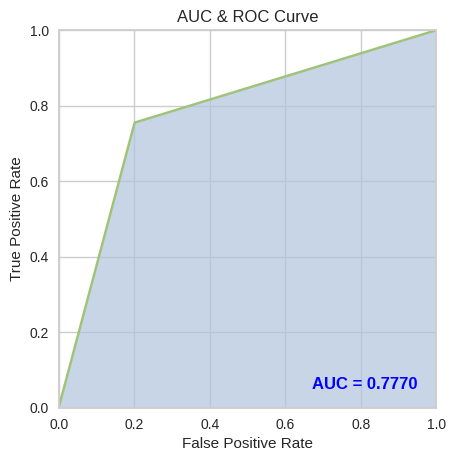

In [ ]:
auc_roc_plot(false_positive_rate, true_positive_rate, auc)

In [ ]:
import re 
# Rename/Clean balanced data columns'name for Pycaret modelisation 
cols_sub = []
for col in train_data.columns:
  sub = re.sub(r'[,/{}":]',"", col)
  cols_sub.append(sub)
train_data.columns = cols_sub

In [ ]:
# confusion matrix

X= train_data[train_data.columns[2:]] 
y= train_data['TARGET']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.3, random_state=42)

light_gbm = LGBMClassifier(**best_params)
light_gbm.fit(X_train, y_train)
y_pred = light_gbm.predict(X_test)
print(light_gbm.classes_)

[0 1]


In [ ]:
mat = confusion_matrix(y_test, y_pred, labels= light_gbm.classes_)

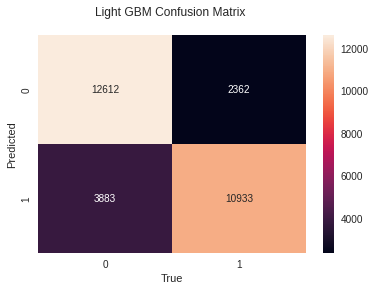

In [ ]:
#labels= ['Insolvent', 'Solvent']
ax= plt.subplot()
sns.heatmap(mat, annot=True, fmt='g', ax=ax)

ax.set_ylabel("Predicted")
ax.set_xlabel("True")
#ax.set_xticklabels(['Insolvent', 'Solvent'])
#ax.set_yticklabels(['Insolvent', 'Solvent'])

ax.set_title("Light GBM Confusion Matrix \n")
plt.show()

## *Documentation for algorithme optimisation and metrics evaluation*

From PyCaret model training, we get ExtraTreesClassifier as the most performant model by default mode as well as some other tree based models. Actually, PyCaret can also do the hyperparameter tuning by the tune_model function. The fact is, our model contains 149 variables which increase largely the computing time, so, it decrease the code performance while tuning hyperparameters. Thus, we use classic method for optimizing the model: **gridsearchCV**. 

At the end of tuning we compare the result with the former one. Here goes the **model optimization**:

- Hyperparameters:
  In tree-based models, there are quite a few commun hyperparameters for tuning, such as 
  
  - max_depth:
  - min_samples_split:
  - min_samples_leaf:


- GridSearchCV
  - scoring: multiple metrics possible
  - refit:
  - cross validation

- GridSearchCV.best_params_, cv_results_

-


An extra tree is an algorithm used for classification and regression tasks. It works by randomly selecting a subset of features and then training a Decision tree on them. The tree is then pruned only to contain the most important features for making predictions. The Extra tree algorithm is considered an efficient and accurate machine learning method.




# Global Model Interpretation 

In [ ]:
kendal_train = train_data
kendal_train.shape

(99300, 97)

Text(0.5, 0.98, 'Feature Importance for Tree Models. Top 20 Features.')

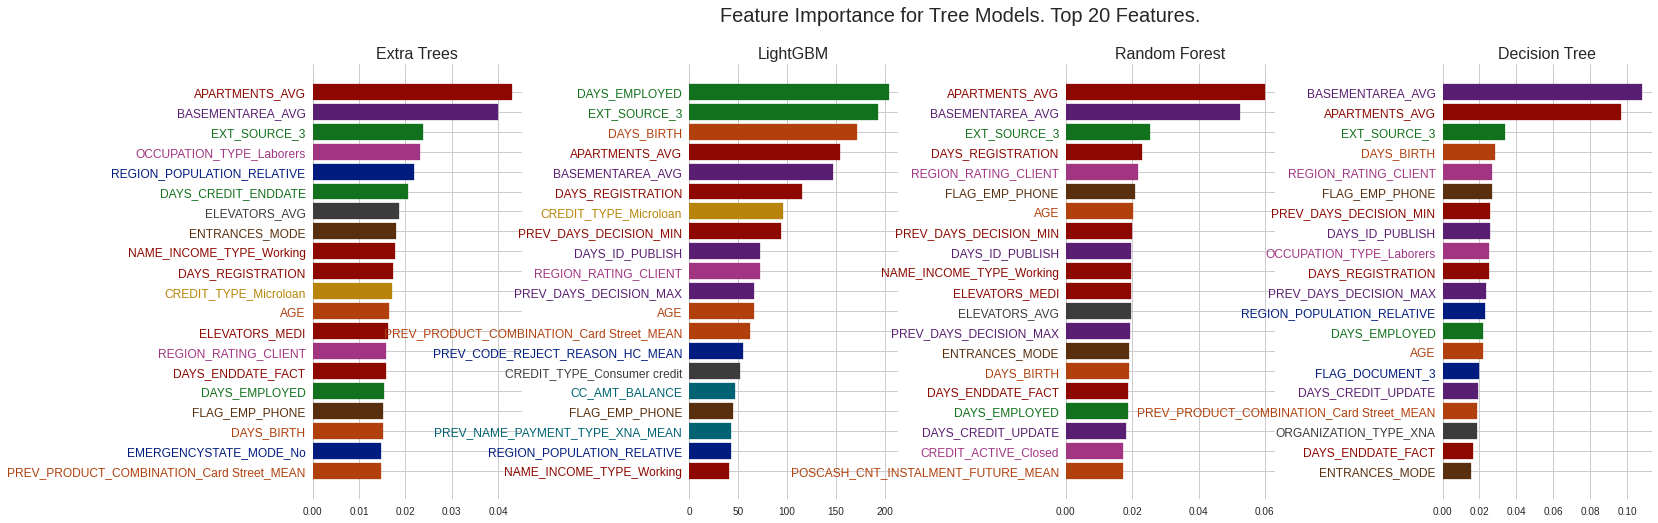

In [ ]:
# Create array of tree based models and plot feature importance scores
tree_models = []

data = kendal_train.iloc[:, 2:]
color_list =  sns.color_palette("dark", len(kendal_train.columns)) 
top_x = 20 # number of x most important features to show
for model in trained_models:
  if hasattr(model["model"]["clf"], 'feature_importances_'): 
    tree_models.append({"name":model["name"], "fi": model["model"]["clf"].feature_importances_}) 
  
  

fig, axs = plt.subplots(1,4, figsize=(24, 8), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = 0.5, wspace=0.8)
axs = axs.ravel()
for i in range(len(tree_models)):
  feature_importance = tree_models[i]["fi"]
  indices = np.argsort(feature_importance)
  indices = indices[-top_x:]

  bars = axs[i].barh(range(len(indices)), feature_importance[indices], color='b', align='center') 
  axs[i].set_title( tree_models[i]["name"], fontweight="normal", fontsize=16)

  plt.sca(axs[i])
  plt.yticks(range(len(indices)), [data.columns[j] for j in indices], fontweight="normal", fontsize=12) 

  # print(len(plt.gca().get_yticklabels()), len(indices))
  for i, ticklabel in enumerate(plt.gca().get_yticklabels()):
    ticklabel.set_color(color_list[indices[i]])  

  for i,bar in enumerate(bars):
    bar.set_color(color_list[indices[i]])
  plt.box(False)
  
plt.suptitle("Feature Importance for Tree Models. Top " + str(top_x) + " Features.", fontsize=20, fontweight="normal")

In [ ]:
tree_models

[{'name': 'Extra Trees',
  'fi': array([0.02190227, 0.08817443, 0.08819906, 0.20147563, 0.04229893,
         0.06503795, 0.18047855, 0.08207106, 0.04175742, 0.01994727,
         0.02665824, 0.01693387, 0.00488847, 0.00859547, 0.00672123,
         0.01275054, 0.01874383, 0.01524547, 0.01734472, 0.00452559,
         0.01995696, 0.00549031, 0.01080273])},
 {'name': 'LightGBM',
  'fi': array([ 98, 460, 400, 435,  82, 176, 456, 219,  99,  44,  82,  56,  18,
          48,  14,  53,  57,  43,  47,   5,  79,  14,  15])},
 {'name': 'Random Forest',
  'fi': array([0.01947869, 0.0766688 , 0.07648747, 0.19217919, 0.04045921,
         0.06132557, 0.18153462, 0.07168204, 0.04010979, 0.02263123,
         0.02631311, 0.01754621, 0.00597048, 0.01616534, 0.01005294,
         0.0200013 , 0.01833714, 0.01877833, 0.02467245, 0.00462568,
         0.0369282 , 0.00620857, 0.01184364])},
 {'name': 'Decision Tree',
  'fi': array([0.01946364, 0.09051061, 0.08873374, 0.17349038, 0.03716114,
         0.04770177, 0

***Top 7 features:***

DAYS_EMPLOYED
EXT_SOURCE_3
DAYS_BIRTH
APARTMENTS_AVG
DAYS_REGISTRATION
CREDIT_TYPE_Microloan
PREV_DAYS_DECISION_MIN

## Global Explaination By Feature Importances

*First selection by pycaret: Tree based models*


Since Pycaret computed results for 14 models, including from "black box" models (ExtraTrees, LightGradientBoosting, GradientBoosting, AdaBoosting, RandomForest) to "white box" models (DecisionTree, Logistic, Ridge, NaiveBayes...). As we can see, Black Box models present genarally better metrics performances comparing to white box models. Thus, we concentrate on evaluation of models with high performances: ExtraTrees, LightGradientBoosting, GradientBoosting, AdaBoosting, RandomForest and also DecisionTree.

*Global explaination:*


For global explaination, which means to see how each feature impact our target prediction, there are multi-ways. Like coefficient interpretation in linear and logistic models. In this projet, we will use features_importance_, the property in tree based models, to help to infer the importance of a feature (Pre-selected by Pycaret). For each decision tree, we can compute the mean decrease of impurity for each feature, the gini importance score. We visualize the average importance for each feature to comprehend each feature's contribution.

# Local Model Interpretation

## Local explaination by SHAP

In [ ]:
!pip install alibi[shap]

In [ ]:
import shap

In [ ]:
subsampled_test_data = shap.sample(test, 500, random_state= 42) # extract 500 samples as background data
#subsampled_test_data = subsampled_test_data.values.reshape(1,-1)
kendal_X_train = kendal_train.drop(columns=['SK_ID_CURR','TARGET'])
print(subsampled_test_data.shape, kendal_X_train.shape)

(500, 23) (20000, 23)


In [ ]:
start_time = time.time()
explainer = shap.TreeExplainer(light_gbm)
# compute contribution values on the first sample data
sv = explainer(kendal_X_train)
shap_values = explainer.shap_values(subsampled_test_data)
run_time = time.time() - start_time

print("Tree Explainer SHAP run time: ", round(run_time,3) , " seconds. ", "Extra Trees Classifier")
print("SHAP expected value: ", explainer.expected_value)
print("Model mean value: ", light_gbm.predict_proba(kendal_X_train).mean(axis=0))
print("Model prediction for test data", light_gbm.predict_proba(subsampled_test_data)[0:10])

Tree Explainer SHAP run time:  532.741  seconds.  Extra Trees Classifier
SHAP expected value:  [0.49878571 0.50121429]
Model mean value:  [0.49884635 0.50115365]
Model prediction for test data [[0.35180297 0.64819703]
 [0.56499293 0.43500707]
 [0.36884407 0.63115593]
 [0.57226566 0.42773434]
 [0.5187631  0.4812369 ]
 [0.27893977 0.72106023]
 [0.57226566 0.42773434]
 [0.31143918 0.68856082]
 [0.36868366 0.63131634]
 [0.65469061 0.34530939]]


In [ ]:
sv_test = explainer(subsampled_test_data)

In [ ]:
shap_values[1][0]

array([ 1.88630014e-01, -6.12514975e-04, -1.32582834e-03, -5.84424850e-04,
        1.64330222e-03,  6.82647441e-03,  1.14600479e-02, -1.09463027e-03,
        5.76734308e-04,  1.05162366e-03, -2.07595906e-03, -1.45869453e-03,
        5.27538371e-04, -1.02741625e-03, -2.33464256e-03, -2.80385255e-02,
        2.87315812e-02, -5.32761950e-02,  9.95981778e-04,  4.66720333e-03,
       -7.64541714e-03, -9.59117935e-05,  1.44240059e-03])

In [ ]:
len(subsampled_test_data.index)

500

In [ ]:
explainer.expected_value[0]

0.49878571428571516

In [ ]:
shap.initjs()
# plot features' contributions in force plot
shap.force_plot(explainer.expected_value[0], shap_values[0][85], subsampled_test_data.iloc[0,:], feature_names= kendal_X_train.columns) # plot instance 159 on target=0

In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1][85], subsampled_test_data.iloc[0,:], feature_names= kendal_X_train.columns) # plot instance 159 on target=1

In [ ]:
print(shap_values[0].shape, shap_values[1].shape)

(500, 23) (500, 23)


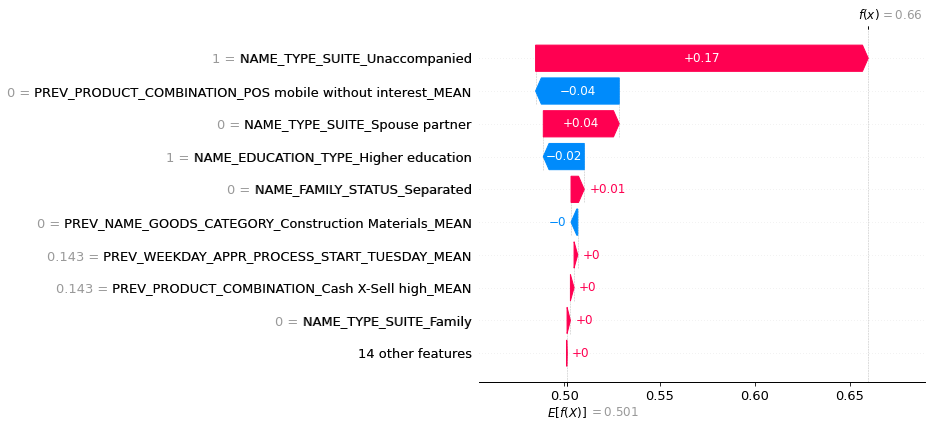

In [ ]:
# plot features' contributions in waterfall plot
shap.initjs()
#shap.waterfall_plot(explainer.expected_value, shap_values[0][159])
#shap.plots.waterfall(shap_values[0][159], max_display=20)
exp = shap.Explanation(sv_test[:,:,1], sv_test.base_values[:,1], kendal_test_X, feature_names=kendal_test_X.columns) # class 1
idx=159
shap.waterfall_plot(exp[idx])

# Pipeline for dashbord

In [ ]:
model_train= pd.read_csv("/gdrive/MyDrive/P7dataset/model_data_train.csv")
model_test= pd.read_csv("/gdrive/MyDrive/P7dataset/model_data_test.csv")

In [ ]:
print(model_train.shape, model_test.shape)
model_test.head()

(99300, 97) (48744, 97)


SK_ID_CURR  TARGET  CODE_GENDER  AMT_GOODS_PRICE  \
0      100001     NaN            1        450000.00   
1      100005     NaN            0        180000.00   
2      100013     NaN            0        630000.00   
3      100028     NaN            1       1575000.00   
4      100038     NaN            0        625500.00   

   REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  \
0                        0.02      -19241          -2329           -5170.00   
1                        0.04      -18064          -4469           -9118.00   
2                        0.02      -20038          -4458           -2175.00   
3                        0.03      -13976          -1866           -2000.00   
4                        0.01      -13040          -2191           -4000.00   

   DAYS_ID_PUBLISH  FLAG_EMP_PHONE  REGION_RATING_CLIENT  \
0             -812               1                     2   
1            -1623               1                     2   
2            -3503               1                     2   
3            -4208               1                     2   
4            -4262               1                     2   

   REGION_RATING_CLIENT_W_CITY  REG_CITY_NOT_LIVE_CITY  \
0                            2                       0   
1                            2                       0   
2                            2                       0   
3                            2                       0   
4                            2                       0   

   REG_CITY_NOT_WORK_CITY  EXT_SOURCE_1  EXT_SOURCE_2  EXT_SOURCE_3  \
0                       0          0.75          0.79          0.16   
1                       0          0.56          0.29          0.43   
2                       0          0.00          0.70          0.61   
3                       0          0.53          0.51          0.61   
4                       1          0.20          0.43          0.00   

   APARTMENTS_AVG  BASEMENTAREA_AVG  YEARS_BEGINEXPLUATATION_AVG  \
0            0.07              0.06                         0.97   
1            0.00              0.00                         0.00   
2            0.00              0.00                         0.00   
3            0.31              0.20                         1.00   
4            0.00              0.00                         0.00   

   YEARS_BUILD_AVG  ELEVATORS_AVG  ENTRANCES_AVG  FLOORSMAX_AVG  \
0             0.00           0.00           0.14           0.12   
1             0.00           0.00           0.00           0.00   
2             0.00           0.00           0.00           0.00   
3             0.96           0.32           0.28           0.38   
4             0.00           0.00           0.00           0.00   

   FLOORSMIN_AVG  LIVINGAREA_AVG  APARTMENTS_MODE  \
0           0.00            0.05             0.07   
1           0.00            0.00             0.00   
2           0.00            0.00             0.00   
3           0.04            0.37             0.31   
4           0.00            0.00             0.00   

   YEARS_BEGINEXPLUATATION_MODE  ELEVATORS_MODE  ENTRANCES_MODE  \
0                          0.97            0.00            0.14   
1                          0.00            0.00            0.00   
2                          0.00            0.00            0.00   
3                          1.00            0.32            0.28   
4                          0.00            0.00            0.00   

   FLOORSMAX_MODE  FLOORSMIN_MODE  LIVINGAREA_MODE  APARTMENTS_MEDI  \
0            0.12            0.00             0.05             0.07   
1            0.00            0.00             0.00             0.00   
2            0.00            0.00             0.00             0.00   
3            0.38            0.04             0.38             0.31   
4            0.00            0.00             0.00             0.00   

   BASEMENTAREA_MEDI  YEARS_BEGINEXPLUATATION_MEDI  YEARS_BUILD_MEDI  \
0               0.06       

In [ ]:
model_train.head()

SK_ID_CURR  TARGET  CODE_GENDER  AMT_GOODS_PRICE  \
0      333721       0            0       1102500.00   
1      110157       0            1        720000.00   
2      276815       0            1        360000.00   
3      353213       0            1        225000.00   
4      447111       0            1       1800000.00   

   REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  \
0                        0.02      -11763           -688            -500.00   
1                        0.05      -23199         365243           -4264.00   
2                        0.01      -19165          -3432           -4524.00   
3                        0.02      -10416          -1154           -4766.00   
4                        0.00      -12125          -3256           -1913.00   

   DAYS_ID_PUBLISH  FLAG_EMP_PHONE  REGION_RATING_CLIENT  \
0            -3325               1                     3   
1            -4151               0                     1   
2            -2558               1                     2   
3            -3037               1                     2   
4            -4286               1                     1   

   REGION_RATING_CLIENT_W_CITY  REG_CITY_NOT_LIVE_CITY  \
0                            3                       0   
1                            1                       0   
2                            2                       0   
3                            2                       0   
4                            1                       0   

   REG_CITY_NOT_WORK_CITY  EXT_SOURCE_1  EXT_SOURCE_2  EXT_SOURCE_3  \
0                       0          0.00          0.62          0.65   
1                       0          0.00          0.73          0.64   
2                       0          0.81          0.67          0.11   
3                       1          0.57          0.30          0.19   
4                       0          0.45          0.66          0.44   

   APARTMENTS_AVG  BASEMENTAREA_AVG  YEARS_BEGINEXPLUATATION_AVG  \
0            0.29              0.20                         0.99   
1            0.08              0.06                         0.98   
2            0.24              0.17                         0.99   
3            0.00              0.00                         0.00   
4            0.00              0.00                         0.00   

   YEARS_BUILD_AVG  ELEVATORS_AVG  ENTRANCES_AVG  FLOORSMAX_AVG  \
0             0.00           0.28           0.24           0.38   
1             0.69           0.02           0.12           0.19   
2             0.89           0.24           0.21           0.38   
3             0.00           0.00           0.00           0.00   
4             0.00           0.00           0.00           0.00   

   FLOORSMIN_AVG  LIVINGAREA_AVG  APARTMENTS_MODE  \
0           0.00            0.06             0.30   
1           0.23            0.07             0.08   
2           0.42            0.26             0.24   
3           0.00            0.00             0.00   
4           0.00            0.00             0.00   

   YEARS_BEGINEXPLUATATION_MODE  ELEVATORS_MODE  ENTRANCES_MODE  \
0                          0.99            0.28            0.24   
1                          0.98            0.00            0.14   
2                          0.99            0.24            0.21   
3                          0.00            0.00            0.00   
4                          0.00            0.00            0.00   

   FLOORSMAX_MODE  FLOORSMIN_MODE  LIVINGAREA_MODE  APARTMENTS_MEDI  \
0            0.38            0.00             0.07             0.30   
1            0.17            0.21             0.05             0.08   
2            0.38            0.42             0.27             0.24   
3            0.00            0.00             0.00             0.00   
4            0.00            0.00             0.00             0.00   

   BASEMENTAREA_MEDI  YEARS_BEGINEXPLUATATION_MEDI  YEARS_BUILD_MEDI  \
0               0.20       

In [ ]:
curr_train = model_train.drop(columns= ['SK_ID_CURR', 'TARGET'])
curr_train.head()

CODE_GENDER  AMT_GOODS_PRICE  REGION_POPULATION_RELATIVE  DAYS_BIRTH  \
0            0       1102500.00                        0.02      -11763   
1            1        720000.00                        0.05      -23199   
2            1        360000.00                        0.01      -19165   
3            1        225000.00                        0.02      -10416   
4            1       1800000.00                        0.00      -12125   

   DAYS_EMPLOYED  DAYS_REGISTRATION  DAYS_ID_PUBLISH  FLAG_EMP_PHONE  \
0           -688            -500.00            -3325               1   
1         365243           -4264.00            -4151               0   
2          -3432           -4524.00            -2558               1   
3          -1154           -4766.00            -3037               1   
4          -3256           -1913.00            -4286               1   

   REGION_RATING_CLIENT  REGION_RATING_CLIENT_W_CITY  REG_CITY_NOT_LIVE_CITY  \
0                     3                            3                       0   
1                     1                            1                       0   
2                     2                            2                       0   
3                     2                            2                       0   
4                     1                            1                       0   

   REG_CITY_NOT_WORK_CITY  EXT_SOURCE_1  EXT_SOURCE_2  EXT_SOURCE_3  \
0                       0          0.00          0.62          0.65   
1                       0          0.00          0.73          0.64   
2                       0          0.81          0.67          0.11   
3                       1          0.57          0.30          0.19   
4                       0          0.45          0.66          0.44   

   APARTMENTS_AVG  BASEMENTAREA_AVG  YEARS_BEGINEXPLUATATION_AVG  \
0            0.29              0.20                         0.99   
1            0.08              0.06                         0.98   
2            0.24              0.17                         0.99   
3            0.00              0.00                         0.00   
4            0.00              0.00                         0.00   

   YEARS_BUILD_AVG  ELEVATORS_AVG  ENTRANCES_AVG  FLOORSMAX_AVG  \
0             0.00           0.28           0.24           0.38   
1             0.69           0.02           0.12           0.19   
2             0.89           0.24           0.21           0.38   
3             0.00           0.00           0.00           0.00   
4             0.00           0.00           0.00           0.00   

   FLOORSMIN_AVG  LIVINGAREA_AVG  APARTMENTS_MODE  \
0           0.00            0.06             0.30   
1           0.23            0.07             0.08   
2           0.42            0.26             0.24   
3           0.00            0.00             0.00   
4           0.00            0.00             0.00   

   YEARS_BEGINEXPLUATATION_MODE  ELEVATORS_MODE  ENTRANCES_MODE  \
0                          0.99            0.28            0.24   
1                          0.98            0.00            0.14   
2                          0.99            0.24            0.21   
3                          0.00            0.00            0.00   
4                          0.00            0.00            0.00   

   FLOORSMAX_MODE  FLOORSMIN_MODE  LIVINGAREA_MODE  APARTMENTS_MEDI  \
0            0.38            0.00             0.07             0.30   
1            0.17            0.21             0.05             0.08   
2            0.38            0.42             0.27             0.24   
3            0.00            0.00             0.00             0.00   
4            0.00            0.00             0.00             0.00   

   BASEMENTAREA_MEDI  YEARS_BEGINEXPLUATATION_MEDI  YEARS_BUILD_MEDI  \
0               0.20                          0.99              0.00   
1               0.07                          0.98              0.67   
2               0.17              

In [ ]:
model_train_ = pd.concat([model_train[['SK_ID_CURR', 'TARGET']], curr_train], axis=1, join='outer')

In [ ]:
model_train_.head()

SK_ID_CURR  TARGET  CODE_GENDER  AMT_GOODS_PRICE  \
0      333721       0            0       1102500.00   
1      110157       0            1        720000.00   
2      276815       0            1        360000.00   
3      353213       0            1        225000.00   
4      447111       0            1       1800000.00   

   REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  \
0                        0.02      -11763           -688            -500.00   
1                        0.05      -23199         365243           -4264.00   
2                        0.01      -19165          -3432           -4524.00   
3                        0.02      -10416          -1154           -4766.00   
4                        0.00      -12125          -3256           -1913.00   

   DAYS_ID_PUBLISH  FLAG_EMP_PHONE  REGION_RATING_CLIENT  \
0            -3325               1                     3   
1            -4151               0                     1   
2            -2558               1                     2   
3            -3037               1                     2   
4            -4286               1                     1   

   REGION_RATING_CLIENT_W_CITY  REG_CITY_NOT_LIVE_CITY  \
0                            3                       0   
1                            1                       0   
2                            2                       0   
3                            2                       0   
4                            1                       0   

   REG_CITY_NOT_WORK_CITY  EXT_SOURCE_1  EXT_SOURCE_2  EXT_SOURCE_3  \
0                       0          0.00          0.62          0.65   
1                       0          0.00          0.73          0.64   
2                       0          0.81          0.67          0.11   
3                       1          0.57          0.30          0.19   
4                       0          0.45          0.66          0.44   

   APARTMENTS_AVG  BASEMENTAREA_AVG  YEARS_BEGINEXPLUATATION_AVG  \
0            0.29              0.20                         0.99   
1            0.08              0.06                         0.98   
2            0.24              0.17                         0.99   
3            0.00              0.00                         0.00   
4            0.00              0.00                         0.00   

   YEARS_BUILD_AVG  ELEVATORS_AVG  ENTRANCES_AVG  FLOORSMAX_AVG  \
0             0.00           0.28           0.24           0.38   
1             0.69           0.02           0.12           0.19   
2             0.89           0.24           0.21           0.38   
3             0.00           0.00           0.00           0.00   
4             0.00           0.00           0.00           0.00   

   FLOORSMIN_AVG  LIVINGAREA_AVG  APARTMENTS_MODE  \
0           0.00            0.06             0.30   
1           0.23            0.07             0.08   
2           0.42            0.26             0.24   
3           0.00            0.00             0.00   
4           0.00            0.00             0.00   

   YEARS_BEGINEXPLUATATION_MODE  ELEVATORS_MODE  ENTRANCES_MODE  \
0                          0.99            0.28            0.24   
1                          0.98            0.00            0.14   
2                          0.99            0.24            0.21   
3                          0.00            0.00            0.00   
4                          0.00            0.00            0.00   

   FLOORSMAX_MODE  FLOORSMIN_MODE  LIVINGAREA_MODE  APARTMENTS_MEDI  \
0            0.38            0.00             0.07             0.30   
1            0.17            0.21             0.05             0.08   
2            0.38            0.42             0.27             0.24   
3            0.00            0.00             0.00             0.00   
4            0.00            0.00             0.00             0.00   

   BASEMENTAREA_MEDI  YEARS_BEGINEXPLUATATION_MEDI  YEARS_BUILD_MEDI  \
0               0.20       

In [ ]:
import re 
# Remove specific characters from data columns' names
cols_sub = []
for col in model_train_.columns:
  sub = re.sub(r'[,/{}":]',"", col)
  cols_sub.append(sub)
model_train_.columns = cols_sub
model_test.columns = cols_sub

In [ ]:
model_train_.to_csv("model_data_train.csv", index=False) 
!cp model_data_train.csv "/gdrive/MyDrive/P7dataset/"
model_test.to_csv("model_data_test.csv", index=False) 
!cp model_data_test.csv "/gdrive/MyDrive/P7dataset/"

In [ ]:
print(model_train_.shape, model_test.shape)

(99300, 97) (48744, 97)


## Create a new model on selected features

In [ ]:
model_train_.head(1)

SK_ID_CURR  TARGET  CODE_GENDER  AMT_GOODS_PRICE  \
0      333721       0            0       1102500.00   

   REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  \
0                        0.02      -11763           -688            -500.00   

   DAYS_ID_PUBLISH  FLAG_EMP_PHONE  REGION_RATING_CLIENT  \
0            -3325               1                     3   

   REGION_RATING_CLIENT_W_CITY  REG_CITY_NOT_LIVE_CITY  \
0                            3                       0   

   REG_CITY_NOT_WORK_CITY  EXT_SOURCE_1  EXT_SOURCE_2  EXT_SOURCE_3  \
0                       0          0.00          0.62          0.65   

   APARTMENTS_AVG  BASEMENTAREA_AVG  YEARS_BEGINEXPLUATATION_AVG  \
0            0.29              0.20                         0.99   

   YEARS_BUILD_AVG  ELEVATORS_AVG  ENTRANCES_AVG  FLOORSMAX_AVG  \
0             0.00           0.28           0.24           0.38   

   FLOORSMIN_AVG  LIVINGAREA_AVG  APARTMENTS_MODE  \
0           0.00            0.06             0.30   

   YEARS_BEGINEXPLUATATION_MODE  ELEVATORS_MODE  ENTRANCES_MODE  \
0                          0.99            0.28            0.24   

   FLOORSMAX_MODE  FLOORSMIN_MODE  LIVINGAREA_MODE  APARTMENTS_MEDI  \
0            0.38            0.00             0.07             0.30   

   BASEMENTAREA_MEDI  YEARS_BEGINEXPLUATATION_MEDI  YEARS_BUILD_MEDI  \
0               0.20                          0.99              0.00   

   ELEVATORS_MEDI  ENTRANCES_MEDI  FLOORSMAX_MEDI  FLOORSMIN_MEDI  \
0            0.28            0.24            0.38            0.00   

   LIVINGAREA_MEDI  TOTALAREA_MODE  DAYS_LAST_PHONE_CHANGE  FLAG_DOCUMENT_3  \
0             0.07            0.24                    0.00                1   

   AGE  NAME_INCOME_TYPE_Pensioner  NAME_INCOME_TYPE_Working  \
0   32                           0                         1   

   NAME_EDUCATION_TYPE_Higher education  \
0                                     0   

   NAME_EDUCATION_TYPE_Secondary  secondary special  OCCUPATION_TYPE_Laborers  \
0                                                 1                         0   

   ORGANIZATION_TYPE_XNA  HOUSETYPE_MODE_block of flats  \
0                      0                              1   

   WALLSMATERIAL_MODE_Panel  EMERGENCYSTATE_MODE_No  DAYS_CREDIT  \
0                         1                       1     -1048.94   

   DAYS_CREDIT_ENDDATE  DAYS_ENDDATE_FACT  DAYS_CREDIT_UPDATE  \
0               883.87           -1010.30             -720.50   

   CREDIT_ACTIVE_Active  CREDIT_ACTIVE_Closed  CREDIT_TYPE_Consumer credit  \
0                  0.38                  0.62                         0.81   

   CREDIT_TYPE_Microloan  CC_AMT_BALANCE  CC_AMT_DRAWINGS_ATM_CURRENT  \
0                   0.00            0.00                         0.00   

   CC_AMT_DRAWINGS_CURRENT  CC_AMT_INST_MIN_REGULARITY  \
0                     0.00                        0.00   

   CC_AMT_RECEIVABLE_PRINCIPAL  CC_AMT_RECIVABLE  CC_AMT_TOTAL_RECEIVABLE  \
0                         0.00              0.00                     0.00   

   CC_CNT_DRAWINGS_ATM_CURRENT  CC_CNT_DRAWINGS_CURRENT  \
0                         0.00                     0.00   

   CC_CNT_DRAWINGS_POS_CURRENT  INS_D_A  INS_D_A.1  \
0                         0.00  -397.00    -410.90   

   POSCASH_CNT_INSTALMENT_FUTURE_MEAN  PREV_AMT_ANNUITY_SUM  \
0                                6.10              11718.93   

   PREV_DAYS_DECISION_MIN  PREV_DAYS_DECISION_MAX  PREV_DAYS_DECISION_MEAN  \
0                 -496.67                 -496.67                  -496.67   

   PREV_NAME_CONTRACT_TYPE_Revolving loans_MEAN  \
0                                          0.00   

   PREV_NAME_CONTRACT_STATUS_Approved_MEAN  \
0                                     1.00   

   PREV_NAME_CONTRACT_STATUS_Refused_MEAN  PREV_NAME_PAYMENT_TYPE_XNA_MEAN  \
0                                    0.00                             0.33   

   PREV_CODE_REJECT_REASON_HC_MEAN  PREV_CODE

In [ ]:
features = [
            'SK_ID_CURR',
            'TARGET',
            'DAYS_EMPLOYED',
            'EXT_SOURCE_3',
            'DAYS_BIRTH',
            'APARTMENTS_AVG',
            'DAYS_REGISTRATION',
            'CREDIT_TYPE_Microloan',
            'PREV_DAYS_DECISION_MIN']

In [ ]:
features_train = model_train_.loc[:, features]
features_test = model_test.loc[:, features]

In [ ]:
features_train.to_csv("features_train.csv", index=False) 
!cp features_train.csv "/gdrive/MyDrive/P7dataset/"
features_test.to_csv("features_test.csv", index=False) 
!cp features_test.csv "/gdrive/MyDrive/P7dataset/"

## Create a new model on selected features

In [ ]:
features_train = pd.read_csv("/gdrive/MyDrive/P7dataset/features_train.csv")
features_test = pd.read_csv("/gdrive/MyDrive/P7dataset/features_test.csv")

In [ ]:
features_train.head(1)

SK_ID_CURR  TARGET  DAYS_EMPLOYED  EXT_SOURCE_3  DAYS_BIRTH  \
0      333721       0           -688          0.65      -11763   

   APARTMENTS_AVG  DAYS_REGISTRATION  CREDIT_TYPE_Microloan  \
0            0.29            -500.00                   0.00   

   PREV_DAYS_DECISION_MIN  
0                 -496.67

In [ ]:
X= features_train[features_train.columns[2:]] 
y= features_train['TARGET']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.3, random_state=42)

In [ ]:
grid = setup(data = X, target=y, html=False, verbose=True)

                    Description             Value
0                    Session id              8081
1                        Target            TARGET
2                   Target type            Binary
3           Original data shape        (99300, 8)
4        Transformed data shape        (99300, 8)
5   Transformed train set shape        (69510, 8)
6    Transformed test set shape        (29790, 8)
7              Numeric features                 7
8                    Preprocess              True
9               Imputation type            simple
10           Numeric imputation              mean
11       Categorical imputation              mode
12               Fold Generator   StratifiedKFold
13                  Fold Number                10
14                     CPU Jobs                -1
15                      Use GPU             False
16               Log Experiment             False
17              Experiment Name  clf-default-name
18                          USI              00b8


In [ ]:
best = compare_models()

                                    Model  Accuracy  AUC  Recall  Prec.   F1  \
lightgbm  Light Gradient Boosting Machine      0.69 0.76    0.67   0.69 0.68   
et                 Extra Trees Classifier      0.68 0.75    0.68   0.68 0.68   
rf               Random Forest Classifier      0.68 0.74    0.67   0.68 0.68   
gbc          Gradient Boosting Classifier      0.68 0.74    0.68   0.67 0.68   
ada                  Ada Boost Classifier      0.67 0.73    0.67   0.67 0.67   
qda       Quadratic Discriminant Analysis      0.63 0.67    0.56   0.65 0.60   
ridge                    Ridge Classifier      0.62 0.00    0.63   0.62 0.62   
lda          Linear Discriminant Analysis      0.62 0.66    0.63   0.62 0.62   
dt               Decision Tree Classifier      0.60 0.60    0.61   0.60 0.60   
nb                            Naive Bayes      0.57 0.60    0.76   0.55 0.64   
knn                K Neighbors Classifier      0.57 0.59    0.58   0.56 0.57   
lr                    Logistic Regressio

In [ ]:
light_gbm = create_model(best)

      Accuracy  AUC  Recall  Prec.   F1  Kappa  MCC
Fold                                               
0         0.69 0.75    0.67   0.69 0.68   0.37 0.37
1         0.69 0.76    0.67   0.70 0.68   0.38 0.38
2         0.69 0.76    0.67   0.70 0.68   0.38 0.38
3         0.69 0.76    0.68   0.69 0.68   0.38 0.38
4         0.69 0.77    0.67   0.70 0.69   0.39 0.39
5         0.68 0.74    0.67   0.68 0.67   0.36 0.36
6         0.68 0.76    0.66   0.69 0.68   0.37 0.37
7         0.69 0.76    0.67   0.70 0.68   0.37 0.37
8         0.68 0.75    0.66   0.68 0.67   0.36 0.36
9         0.68 0.75    0.65   0.69 0.67   0.35 0.35
Mean      0.69 0.76    0.67   0.69 0.68   0.37 0.37
Std       0.01 0.01    0.01   0.01 0.01   0.01 0.01


In [ ]:
print(best)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=8081, reg_alpha=0.0, reg_lambda=0.0, silent='warn',
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)


In [ ]:
tuned_model = tune_model(light_gbm)

Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


      Accuracy  AUC  Recall  Prec.   F1  Kappa  MCC
Fold                                               
0         0.69 0.75    0.67   0.69 0.68   0.37 0.37
1         0.69 0.76    0.66   0.71 0.68   0.38 0.39
2         0.70 0.76    0.68   0.70 0.69   0.39 0.39
3         0.69 0.76    0.67   0.70 0.68   0.38 0.38
4         0.70 0.77    0.67   0.71 0.69   0.39 0.39
5         0.68 0.75    0.66   0.69 0.67   0.36 0.36
6         0.69 0.76    0.66   0.70 0.68   0.37 0.37
7         0.68 0.75    0.66   0.69 0.68   0.36 0.36
8         0.68 0.75    0.66   0.69 0.68   0.37 0.37
9         0.68 0.75    0.66   0.69 0.67   0.36 0.36
Mean      0.69 0.76    0.66   0.70 0.68   0.37 0.37
Std       0.01 0.01    0.01   0.01 0.01   0.01 0.01


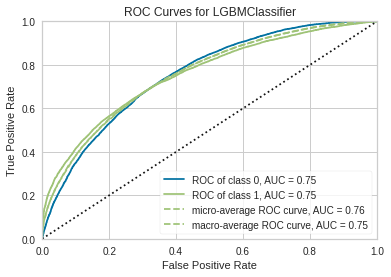

In [ ]:
plot_model(tuned_model, plot= 'auc')

## First model : no threshold applied

In [ ]:
scaler= MinMaxScaler()
predict_pipeline = Pipeline([('MinMaxScaler', scaler),
                             ('Classifier', best)
                             ])
predict_pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('MinMaxScaler',
                 MinMaxScaler(clip=False, copy=True, feature_range=(0, 1))),
                ('Classifier',
                 LGBMClassifier(boosting_type='gbdt', class_weight=None,
                                colsample_bytree=1.0, importance_type='split',
                                learning_rate=0.1, max_depth=-1,
                                min_child_samples=20, min_child_weight=0.001,
                                min_split_gain=0.0, n_estimators=100, n_jobs=-1,
                                num_leaves=31, objective=None,
                                random_state=8081, reg_alpha=0.0,
                                reg_lambda=0.0, silent='warn', subsample=1.0,
                                subsample_for_bin=200000, subsample_freq=0))],
         verbose=False)

### Save the first model in pkl

In [ ]:
#!pip install mlflow 
#!pip install pyngrok --quiet

In [ ]:
import mlflow
from mlflow.models.signature import infer_signature

In [ ]:
signature = infer_signature(X_train, y_train)

In [ ]:
# save sklearn model
mlflow.sklearn.save_model(predict_pipeline, 'mlflow_model_0', signature=signature)

2023/01/22 12:36:56 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: mlflow_model_0/model.pkl, flavor: sklearn), fall back to return ['scikit-learn==1.0.2', 'cloudpickle==2.2.0']. Set logging level to DEBUG to see the full traceback.


In [ ]:
!cp mlflow_model_0 "/gdrive/MyDrive/P7dataset/"

cp: -r not specified; omitting directory 'mlflow_model_0'


## Second model: Apply the computed threshold to prediction

In [ ]:
!pip install sklego

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 230.9/230.9 KB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 KB 9.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 59.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82829 sha256=b3deb65072b595de0c34b3c4b63db38602ae4bbdbebdeb7a600164cd3ffae37e
  Stored in directory: /root/.cache/pip/wheels/a9/3a/67/06a8950e053725912e6a8c42c4a3a241410f6487b8402542ea
  Created wheel for pynndescent: filename=pynndescent-0.5.8-py3-none-any.whl size=55513 sha256=61d8b59519a5eeb1479779dbb164127e17c1880cdda367ea6493ecc74886b309
  Stored in directory: /root/.cache/pip/wheels/1c/63/3a/29954bca1a27ba100ed8c27973a78cb71b43dc67aed62e80c3
Successfully built umap-learn pynndescent


In [ ]:
from sklego.meta import Thresholder

In [ ]:
X= features_train[features_train.columns[2:]] 
y= features_train['TARGET']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.3, random_state=42)

In [ ]:
best_model_thres = Thresholder(best, 0.75, refit=True)

## Fit new pipeline

In [ ]:
type(best_model_thres)

sklego.meta.thresholder.Thresholder

In [ ]:
predict_pipeline = Pipeline([('MinMaxScaler', scaler),
                             ('Classifier', best_model_thres)
                             ])
predict_pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('MinMaxScaler',
                 MinMaxScaler(clip=False, copy=True, feature_range=(0, 1))),
                ('Classifier',
                 Thresholder(model=LGBMClassifier(boosting_type='gbdt',
                                                  class_weight=None,
                                                  colsample_bytree=1.0,
                                                  importance_type='split',
                                                  learning_rate=0.1,
                                                  max_depth=-1,
                                                  min_child_samples=20,
                                                  min_child_weight=0.001,
                                                  min_split_gain=0.0,
                                                  n_estimators=100, n_jobs=-1,
                                                  num_leaves=31, objective=None,
                                        

In [ ]:
proba_prediction = predict_pipeline.predict_proba(features_test.iloc[:,2:])
proba_prediction[0:20]

array([[0.41710686, 0.58289314],
       [0.63170504, 0.36829496],
       [0.76378427, 0.23621573],
       [0.70055162, 0.29944838],
       [0.38431129, 0.61568871],
       [0.80124669, 0.19875331],
       [0.77091141, 0.22908859],
       [0.35586002, 0.64413998],
       [0.52803744, 0.47196256],
       [0.39750847, 0.60249153],
       [0.18751525, 0.81248475],
       [0.51862511, 0.48137489],
       [0.39443851, 0.60556149],
       [0.69082824, 0.30917176],
       [0.56771791, 0.43228209],
       [0.1758226 , 0.8241774 ],
       [0.54455131, 0.45544869],
       [0.72618382, 0.27381618],
       [0.60517598, 0.39482402],
       [0.53980009, 0.46019991]])

In [ ]:
class_prediction = predict_pipeline.predict(features_test.iloc[:,2:])
class_prediction[0:20]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0])

In [ ]:
predict_pipeline.score(X_train, y_train)

0.7029060566824917

### Save the second model in pkl

In [ ]:
signature = infer_signature(X_train, y_train)

In [ ]:
# save sklearn model
mlflow.sklearn.save_model(predict_pipeline, 'mlflow_model', signature=signature)

2023/01/22 12:37:07 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: mlflow_model/model.pkl, flavor: sklearn), fall back to return ['scikit-learn==1.0.2', 'cloudpickle==2.2.0']. Set logging level to DEBUG to see the full traceback.


In [ ]:
!cp mlflow_model "/gdrive/MyDrive/P7dataset/"

cp: -r not specified; omitting directory 'mlflow_model'


# Local Model Interpretation

Model signature: description des entrées et sorties du modèle

Model Inplut Example: example d'une entrée valide

La signature du modèle permet de renseigner le nom des colonnes et leurs types afin de vérifier si ils sont similaires lors de la prédiction

https://github.com/pyenv/pyenv#installation